In [1]:
import os
os.getcwd()

'/home/fusion/jupyterhub-notebooks/GTM Model'

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Reading the data

In [3]:
md=pd.read_csv('Modelling data after imputation 26may2020 V4.csv',  thousands=',', low_memory=False)

In [4]:
md.columns=[x.lower() for x in md.columns]
del md['unnamed: 0']
md.shape

(1040509, 129)

In [5]:
# md.head()
# print(md['bpn'].map(str).str.len().value_counts(), md['bpn'].map(str).str.len().value_counts().sum())
# print(md['autoink_flag'].value_counts(), md['autoink_flag'].value_counts().sum())
# print(md['outreach_flag'].value_counts(),md['outreach_flag'].value_counts().sum())

8    1040509
Name: bpn, dtype: int64 1040509
0    1023159
1      17350
Name: autoink_flag, dtype: int64 1040509
1.0    587327
0.0    453182
Name: outreach_flag, dtype: int64 1040509


In [5]:
md['bpn'][md['bpn'].notnull()] =md['bpn'][md['bpn'].notnull()].astype(int).map(str).apply(lambda x: x.zfill(10))
md['outreach_flag']=md['outreach_flag'].astype(int)
#md.serial[md['serial'].notnull()] = md['serial'][md['serial'].notnull()].astype(int).map(str).apply(lambda x: x.zfill(7))
#md.naicscd[md['naicscd'].notnull()] = md['naicscd'][md['naicscd'].notnull()].astype(int).map(str).apply(lambda x: x.zfill(6))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
# md.cmp_base_flag.unique()

array(['No', 'Yes'], dtype=object)

In [15]:
# t=md.bpn.value_counts()
# t=pd.DataFrame(t)
# t['bpn_id']=t.index
# t=t[t.bpn>=8]
# md[md.bpn.isin(t.bpn_id[0:1])][['rental_timing_segment', 'model_month']]
# md[md.bpn.isin(t.bpn_id[0:4])].to_csv('example of bpn with campaign in three months.csv')

,rental_timing_segment,model_month
699106,d. 37-48,Feb20
725752,d. 37-48,Nov19
826349,d. 37-48,Jun19
833680,d. 37-48,Jul19
851188,d. 37-48,Sep19
867354,d. 37-48,Oct19
893999,d. 37-48,Jan20
899248,d. 37-48,Dec19
930131,c. 25-36,May19
975975,c. 25-36,Apr19


In [6]:
## CONSIDERING ONLY CAMPAIGN BASE DATA 

md = md[(md.cmp_base_flag=='Yes')]
print(md.shape)
md['eng1_rgt_st']=md['eng1_rgt_st'].astype(int)
md['third_party_flag']=md['third_party_flag'].astype(int)
md['ach_setup']=md['ach_setup'].astype(int)
md['cc_setup']=md['cc_setup'].astype(int)
md['auto_pay']=md['auto_pay'].astype(int)
md['paperless']=md['paperless'].astype(int)
md['eng1_flg']=md['eng1_flg'].astype(int)

md['temp']=np.nan
md['temp'][(md['eligibility']=='Yes') | (md['eligibility']=='Y')]=1
md['temp'][(md['eligibility']!='Yes') & (md['eligibility']!='Y')]=0
md['eligibility']=md['temp']
md['eligibility']=md['eligibility'].astype(int)
del md['temp']

md['list_minus_ti'][md['list_minus_ti']<0]=0
md['discount_amount_zdv1']=md['discount_amount_zdv1']*(-1)

md['days_okta_1signin'][md['days_okta_1signin']<0]=np.nan
md['days_eng_rgt'][md['days_eng_rgt']<0]=np.nan

md['lease_timing_segment'][(md['rental_timing_segment'].notnull()) & (md['lease_timing_segment'].isnull())]='not_lease'
md['rental_timing_segment'][(md['lease_timing_segment'].notnull()) & (md['rental_timing_segment'].isnull())]='not_rental'
# print((md.shape[0]-md['lease_timing_segment'].value_counts().sum())/md.shape[0])
# print((md.shape[0]-md['rental_timing_segment'].value_counts().sum())/md.shape[0])

##--- removing un necessary cols

## effective_flag - removing it as it is created based on ehhective click on campaign outreach which cannot be known in prior
## mails_clicks,tu_mails_clicks,r2l_mails_clicks,cp_mails_clicks -- removed for same reason (KEEPING MAIL SENDS)
## amount, pieces- they represent usage in campaihn month, cannot be known in advance
cols=['bpn','model_month','lease','oppid','serial','conversion_channel','effective_flag',
     'mails_clicks','tu_mails_clicks','r2l_mails_clicks','cp_mails_clicks',
     'amount', 'pieces']
for i in cols:
    del md[i]
    
##---list of cat variables
    
cat_var=['lease_timing_segment','rental_timing_segment','eligibility','usage','campaign','campaign_type','title',
        'outreach_channel','multichannel','stagename','box_segment','your_account_flag','naicscd','pbiseg',
        'naics2','naics3','autoink_flag','promoter_flag','gsb_flag','eng1_rgt_st','ach_setup','cc_setup','auto_pay',
        'paperless','eng1_flg','loyalty','shipping_eligible','third_party_flag','outreach_flag','contract_lro',
        'finalequip','materialgroup']

##------- list of num variables

#num=list(md._get_numeric_data().columns)
num_var= set(md.columns) - set(cat_var) -set(['renewal','cmp_base_flag'])
num_var=list(num_var)
print(num_var)

(886720, 129)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: Settin

['trade_in_amount', 'cp_mail_sends_12mon', 'cp_offers_prv_12m', 'survey_neu', 'cnt_open_oppids', 'amount_12mon', 'r2l_mails_clicks_12mon', 'amount_lag1', 'paymentscore', 'mails_open_12mon', 'amt_grw_prv_qtr', 'r2l_offers_prv_qtr', 'nps_mean', 'disp_calls_cnt', 'case_neu', 'case_compound', 'task_neu', 'pieces_qtr_prv', 'survey_neg', 'cp_offers_prv_qtr', 'tu_mail_sends', 'cp_mail_sends', 'emp_grwth_5_yr_pct', 'eff_disp_calls_cnt_12mon', 'task_neg', 'nps_latest', 'pcs_grw_prv_mth', 'r2l_offers_prv_6m', 'pcs_grw_prv_qtr', 'tot_offers_prv_qtr', 'r2l_mail_sends', 'frtotlmopayment', 'cnt_lease_oppids', 'amt_grw_prv_mth', 'pieces_6m_prv', 'tot_offers_prv_12m', 'nps_min', 'case_pos', 'pieces_lag1', 'sls_grwth_5_yr_pct', 'tu_mail_sends_12mon', 'days_eng_rgt', 'mail_sends', 'num_signins_12m', 'r2l_tu_offers_prv_12m', 'emp_grwth_3_yr_pct', 'r2l_tu_offers_prv_6m', 'disp_calls_cnt_12mon', 'tot_offers_prv_6m', 'amount_6m_prv', 'tu_mails_clicks_12mon', 'r2l_offers_prv_12m', 'days_okta_1signin', 'r2l_m

In [7]:
print(num_var)

['task_compound', 'cnt_lease_open_oppids', 'usagescore', 'r2l_mail_sends', 'task_neg', 'survey_compound', 'cp_mails_open_12mon', 'mail_sends_12mon', 'pieces_qtr_prv', 'eff_disp_calls_cnt_12mon', 'pieces_12mon', 'r2l_mails_open_12mon', 'emp_grwth_5_yr_pct', 'days_eng_rgt', 'amount_12mon', 'tot_offers_prv_6m', 'survey_neg', 'survey_neu', 'tu_offers_prv_6m', 'tu_mail_sends_12mon', 'tu_mails_open_12mon', 'nps_mean', 'monthly_payment', 'paymentscore', 'pcs_grw_prv_qtr', 'tu_mails_clicks_12mon', 'survey_pos', 'case_neu', 'tot_offers_prv_12m', 'discount_amount_zdv1', 'frtotlmopayment', 'list_minus_ti', 'tu_offers_prv_12m', 'cp_offers_prv_6m', 'num_signins_12m', 'case_pos', 'nps_latest', 'amount_qtr_prv', 'task_neu', 'r2l_mails_clicks_12mon', 'cnt_open_oppids', 'sls_grwth_3_yr_pct', 'disp_calls_cnt_12mon', 'case_neg', 'amount_6m_prv', 'amt_grw_prv_mth', 'cp_mail_sends_12mon', 'mails_open_12mon', 'list_price', 'cnt_lease_oppids', 'case_compound', 'sls_grwth_5_yr_pct', 'r2l_tu_offers_prv_12m', '

In [7]:
# cat_var=['lease_timing_segment','rental_timing_segment','eligibility','usage','campaign','campaign_type','title',
#         'outreach_channel','multichannel','stagename','box_segment','your_account_flag','naicscd','pbiseg',
#         'naics2','naics3','autoink_flag','promoter_flag','gsb_flag','eng1_rgt_st','ach_setup','cc_setup','auto_pay',
#         'paperless','eng1_flg','loyalty','shipping_eligible','third_party_flag','outreach_flag','contract_lro',
#         'finalequip','materialgroup']

# ##------- list of num variables

# #num=list(md._get_numeric_data().columns)
# num_var= set(md.columns) - set(cat_var) -set(['renewal','cmp_base_flag'])
# num_var=list(num_var)
# print(num_var)
# print(len(num_var))

['trade_in_amount', 'cp_mail_sends_12mon', 'cp_offers_prv_12m', 'survey_neu', 'cnt_open_oppids', 'amount_12mon', 'r2l_mails_clicks_12mon', 'amount_lag1', 'paymentscore', 'mails_open_12mon', 'amt_grw_prv_qtr', 'r2l_offers_prv_qtr', 'nps_mean', 'disp_calls_cnt', 'case_neu', 'case_compound', 'task_neu', 'pieces_qtr_prv', 'survey_neg', 'cp_offers_prv_qtr', 'tu_mail_sends', 'cp_mail_sends', 'emp_grwth_5_yr_pct', 'eff_disp_calls_cnt_12mon', 'task_neg', 'nps_latest', 'pcs_grw_prv_mth', 'r2l_offers_prv_6m', 'pcs_grw_prv_qtr', 'tot_offers_prv_qtr', 'r2l_mail_sends', 'frtotlmopayment', 'cnt_lease_oppids', 'amt_grw_prv_mth', 'pieces_6m_prv', 'tot_offers_prv_12m', 'nps_min', 'case_pos', 'pieces_lag1', 'sls_grwth_5_yr_pct', 'tu_mail_sends_12mon', 'days_eng_rgt', 'mail_sends', 'num_signins_12m', 'r2l_tu_offers_prv_12m', 'emp_grwth_3_yr_pct', 'r2l_tu_offers_prv_6m', 'disp_calls_cnt_12mon', 'tot_offers_prv_6m', 'amount_6m_prv', 'tu_mails_clicks_12mon', 'r2l_offers_prv_12m', 'days_okta_1signin', 'r2l_m

In [23]:
# for i in md.columns:
#     print(i)
#     print(type(md[i][0]))
#     if type(md[i][0])==str:
#         print(md[i].unique())
#     else:
#         print(md[i][0:4])

model_month
<class 'str'>
['Jan20' 'Nov19' 'Dec19']
bpn
<class 'str'>
['0017068564' '0016618122' '0015020790' ... '0017480190' '0016323864'
 '0016605225']
oppid
<class 'str'>
['0068000000zmRquAAE' '006800000177IIaAAM' '0068000000vAxgcAAC' ...
 '00680000014NHXuAAO' '0068000000vp3TiAAI' '0068000000wdrSYAAY']
lease
<class 'str'>
['B902411001' '0030114968' 'F973755004' ... 40541470 40405884 40447776]
serial
<class 'str'>
['0657247' '0616755' '0819216' ... 760908.0 560519.0 667022.0]
cmp_base_flag
<class 'str'>
['Yes']
contract_lro
<class 'str'>
['Lease' 'Rental']
list_price
<class 'numpy.float64'>
0     300.33
1     217.08
2    6971.44
3    4295.72
Name: list_price, dtype: float64
trade_in_amount
<class 'numpy.float64'>
0      90.0
1      -0.0
2    3842.0
3      -0.0
Name: trade_in_amount, dtype: float64
list_minus_ti
<class 'numpy.float64'>
0     210.33
1     217.08
2    3129.44
3    4295.72
Name: list_minus_ti, dtype: float64
lease_timing_segment
<class 'str'>
['a. <-8' 'g. 10-12' 'b. SL

['Professional, Scientific, and Technical Services' 'Unknown'
 'Wholesale Trade' 'Manufacturing'
 'Administrative and Support and Waste Management and Remediation Services'
 'Finance and Insurance' 'Health Care and Social Assistance'
 'Construction' 'Other Services (except Public Administration)'
 'Retail Trade' 'Mining, Quarrying, and Oil and Gas Extraction'
 'Information' 'Transportation and Warehousing' 'Public Administration'
 'Real Estate and Rental and Leasing' 'Accommodation and Food Services'
 'Arts, Entertainment, and Recreation' 'Educational Services' 'Utilities'
 'Management of Companies and Enterprises'
 'Agriculture, Forestry, Fishing and Hunting'
 'Nonclassifiable Establishments']
naics3
<class 'str'>
['Professional, Scientific, and Technical Services' 'Unknown'
 'Merchant Wholesalers, Durable Goods' 'Apparel Manufacturing'
 'Fabricated Metal Product Manufacturing'
 'Administrative and Support Services'
 'Insurance Carriers and Related Activities'
 'Credit Intermediation 

# Numeric Variables

In [8]:
### ANOVA ANALYSIS OF THE NUMERICAL VARIABLES
anova_res={}
for i in num_var:
    print("{} ========================".format(i))
    df=md[(md[i].notnull())  & (md.cmp_base_flag=='Yes')]
    print('total degree of freedon for anova: {}'.format(df.shape[0]))
    print('degree of freedon for renewal==1 {}'.format(df[df['renewal'] == 1].shape[0]))
    print('degree of freedon for renewal==0: {}'.format(df[df['renewal'] == 0].shape[0]))
    
    o=stats.f_oneway(df[i][df['renewal'] == 0], df[i][df['renewal'] == 1 ])
    print(i + ': the p value for 1way anova: {}'.format(o[1]))
    print(df.groupby(['renewal'])[i].mean())
    l=[o[1]]
#     print(type(l))
    l=l+list(df.groupby(['renewal'])[i].mean())
    l=l+list(df.groupby(['renewal'])[i].median())
    #l=l.append(list(df.groupby(['renewal'])[i].median()))
    print(l)
    anova_res[i]=l

trade_in_amount ========================
total degree of freedon for anova: 886720
degree of freedon for renewal==1 58029
degree of freedon for renewal==0: 828691
trade_in_amount: the p value for 1way anova: 2.287489802870855e-190
renewal
0     58.101995
1    106.761809
Name: trade_in_amount, dtype: float64
[2.287489802870855e-190, 58.101995050025145, 106.76180892312452, -0.0, -0.0]
cp_mail_sends_12mon ========================
total degree of freedon for anova: 886720
degree of freedon for renewal==1 58029
degree of freedon for renewal==0: 828691
cp_mail_sends_12mon: the p value for 1way anova: 2.271286037760106e-05
renewal
0    0.141388
1    0.123507
Name: cp_mail_sends_12mon, dtype: float64
[2.271286037760106e-05, 0.14138804451840312, 0.12350721191128573, 0.0, 0.0]
cp_offers_prv_12m ========================
total degree of freedon for anova: 886720
degree of freedon for renewal==1 58029
degree of freedon for renewal==0: 828691
cp_offers_prv_12m: the p value for 1way anova: 2.05585464

total degree of freedon for anova: 886720
degree of freedon for renewal==1 58029
degree of freedon for renewal==0: 828691
emp_grwth_5_yr_pct: the p value for 1way anova: 0.34209179899593145
renewal
0    5.893199
1    6.105689
Name: emp_grwth_5_yr_pct, dtype: float64
[0.34209179899593145, 5.893199033174006, 6.105688535042823, 0.0, 0.0]
eff_disp_calls_cnt_12mon ========================
total degree of freedon for anova: 886720
degree of freedon for renewal==1 58029
degree of freedon for renewal==0: 828691
eff_disp_calls_cnt_12mon: the p value for 1way anova: 7.467028494543397e-35
renewal
0    0.142718
1    0.090127
Name: eff_disp_calls_cnt_12mon, dtype: float64
[7.467028494543397e-35, 0.1427178526133384, 0.09012735011804443, 0.0, 0.0]
task_neg ========================
total degree of freedon for anova: 886720
degree of freedon for renewal==1 58029
degree of freedon for renewal==0: 828691
task_neg: the p value for 1way anova: 8.34215105347067e-10
renewal
0    0.037075
1    0.035289
Name: 

total degree of freedon for anova: 886720
degree of freedon for renewal==1 58029
degree of freedon for renewal==0: 828691
r2l_tu_offers_prv_12m: the p value for 1way anova: 0.0
renewal
0    0.258935
1    0.092057
Name: r2l_tu_offers_prv_12m, dtype: float64
[0.0, 0.25893487439829804, 0.09205741956607903, 0.0, 0.0]
emp_grwth_3_yr_pct ========================
total degree of freedon for anova: 886720
degree of freedon for renewal==1 58029
degree of freedon for renewal==0: 828691
emp_grwth_3_yr_pct: the p value for 1way anova: 0.6088560888650234
renewal
0    3.695692
1    3.603664
Name: emp_grwth_3_yr_pct, dtype: float64
[0.6088560888650234, 3.695692363015889, 3.60366368539868, 0.0, 0.0]
r2l_tu_offers_prv_6m ========================
total degree of freedon for anova: 886720
degree of freedon for renewal==1 58029
degree of freedon for renewal==0: 828691
r2l_tu_offers_prv_6m: the p value for 1way anova: 0.0
renewal
0    0.258935
1    0.092057
Name: r2l_tu_offers_prv_6m, dtype: float64
[0.0, 

total degree of freedon for anova: 886720
degree of freedon for renewal==1 58029
degree of freedon for renewal==0: 828691
monthly_payment: the p value for 1way anova: 7.211578051744924e-12
renewal
0    56.120968
1    54.266333
Name: monthly_payment, dtype: float64
[7.211578051744924e-12, 56.12096785975411, 54.26633332758551, 38.333333333333336, 43.0]
cp_mails_clicks_12mon ========================
total degree of freedon for anova: 886720
degree of freedon for renewal==1 58029
degree of freedon for renewal==0: 828691
cp_mails_clicks_12mon: the p value for 1way anova: 0.3497269059669069
renewal
0    0.003368
1    0.002912
Name: cp_mails_clicks_12mon, dtype: float64
[0.3497269059669069, 0.003367962244069261, 0.0029123369349807857, 0.0, 0.0]
tu_mails_open_12mon ========================
total degree of freedon for anova: 886720
degree of freedon for renewal==1 58029
degree of freedon for renewal==0: 828691
tu_mails_open_12mon: the p value for 1way anova: 1.5705450466218004e-05
renewal
0    

In [9]:
## ANOVA RESULTS STORED IN DATAFRAME
anova_res_pd=pd.DataFrame.from_dict(anova_res,orient='index')
anova_res_pd.columns=['anova_p_value','non_ren_mean','ren_mean','non_ren_md','ren_md']
anova_res_pd['variable_name']=anova_res_pd.index
anova_res_pd
# anova_res_pd.to_csv('1-way anova summary 26may2020.csv')

,anova_p_value,non_ren_mean,ren_mean,non_ren_md,ren_md,variable_name
trade_in_amount,2.287490e-190,58.101995,106.761809,-0.00,-0.0,trade_in_amount
cp_mail_sends_12mon,2.271286e-05,0.141388,0.123507,0.00,0.0,cp_mail_sends_12mon
cp_offers_prv_12m,2.055855e-133,0.514533,0.652829,0.00,0.0,cp_offers_prv_12m
survey_neu,3.527755e-05,0.013784,0.015757,0.00,0.0,survey_neu
cnt_open_oppids,2.021202e-181,0.876531,0.917231,1.00,1.0,cnt_open_oppids
...,...,...,...,...,...,...
sls_grwth_3_yr_pct,1.671747e-06,1.176621,1.569129,0.00,0.0,sls_grwth_3_yr_pct
r2l_mails_open_12mon,2.901643e-61,0.050844,0.011184,0.00,0.0,r2l_mails_open_12mon
usagescore,0.000000e+00,6.013859,7.051423,4.00,8.0,usagescore
survey_pos,4.043901e-04,0.001627,0.002037,0.00,0.0,survey_pos


In [10]:
## funstion to plot num var
## overlaping histograms of the numerical variable for renewing ang not renewing customers
## boxplot of by renewal (dependent varaible) -- normal and log transformed variable
## boxplot of by renewal (dependent varaible) & contract type i.e. lease/rental -- normal and log transformed variable

def plot_func(i,log_add=1):
    print("{} ========================".format(i))
    df=md[(md[i].notnull())  & (md.cmp_base_flag=='Yes')]    

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 4))
    fig.tight_layout()
    
    plt.subplot(1, 2, 1)
    plt.hist(df[i][df.renewal==0],label='non_renewal',alpha=0.5)
    plt.hist(df[i][df.renewal==1],label='rnewal',alpha=0.5,color='red')
    plt.title(i)
    plt.legend(loc='best')
    plt.subplot(1, 2, 2)
    plt.hist(np.log(log_add+df[i][df.renewal==0]),label='non_renewal',alpha=0.5)
    plt.hist(np.log(log_add+df[i][df.renewal==1]),label='renewal',alpha=0.5,color='red')
    plt.title(i+' log transformed')
    plt.legend(loc='best')
    plt.show()
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 4))
    fig.tight_layout()
    
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df.renewal,y=df[i])
    plt.title(i)
    plt.legend(loc='best')
    plt.subplot(1, 2, 2)
    sns.boxplot( x=df.renewal,y=np.log(log_add+df[i]))
    plt.title(i+' log transformed')
    plt.legend(loc='best')
    plt.show()
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    fig.tight_layout()
    
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df.renewal,y=df[i], hue=df.contract_lro)
    plt.title(i)
    plt.legend(loc='best')
    plt.subplot(1, 2, 2)
    sns.boxplot( x=df.renewal,y=np.log(log_add+df[i]), hue=df.contract_lro)
    plt.title(i+' log transformed')
    plt.legend(loc='best')
    plt.show()

    return()

In [11]:
##----------------- Information Value calculation function
##--------------------------------------------------------

import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin=20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [14]:
md.list_price.describe()

count    886720.000000
mean       1131.882147
std        2933.508129
min           0.000000
25%           0.000000
50%         328.250000
75%         925.660000
max      224688.500000
Name: list_price, dtype: float64

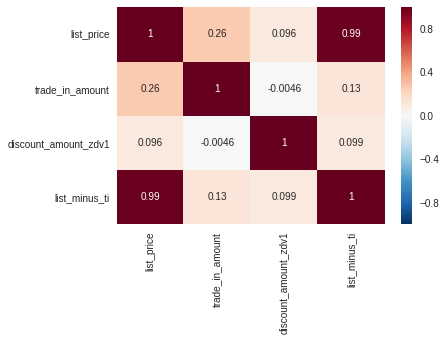

                      anova_p_value  non_ren_mean     ren_mean  non_ren_md  \
list_price             9.226992e-04   1129.150950  1170.885380      300.06   
trade_in_amount       2.287490e-190     58.101995   106.761809       -0.00   
list_minus_ti          5.780105e-01   1071.137929  1064.311108      289.09   
discount_amount_zdv1   3.642799e-04      1.614148     0.785394       -0.00   

                      ren_md         variable_name  
list_price             592.8            list_price  
trade_in_amount         -0.0       trade_in_amount  
list_minus_ti          590.0         list_minus_ti  
discount_amount_zdv1    -0.0  discount_amount_zdv1  
list_price ========================


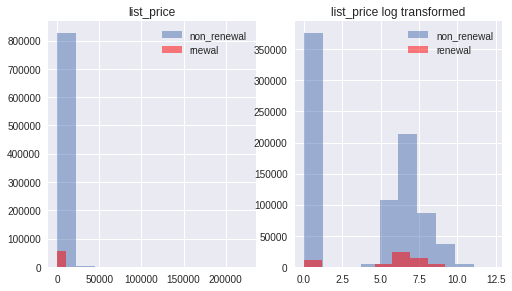

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


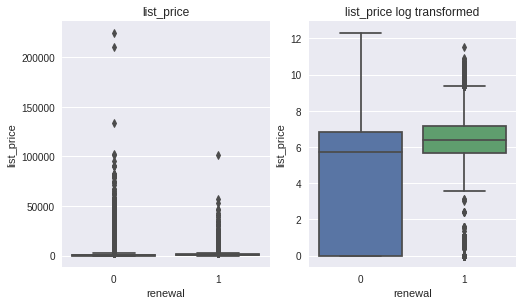

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

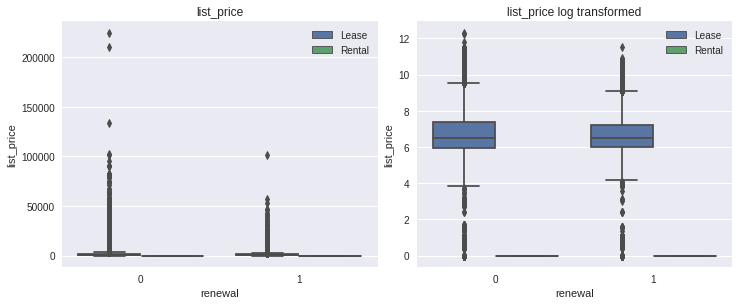

trade_in_amount ========================


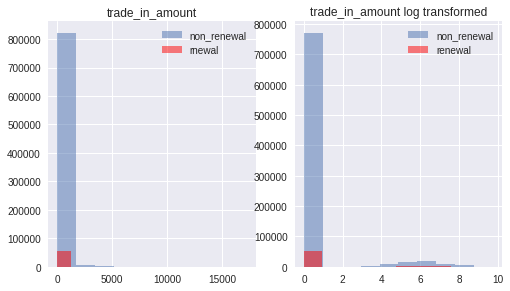

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


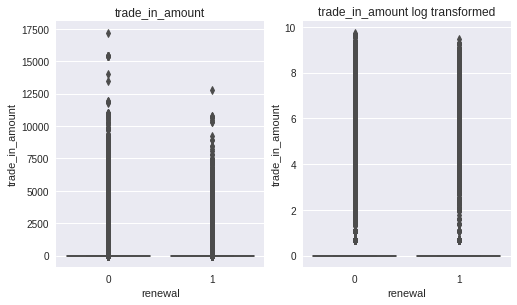

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

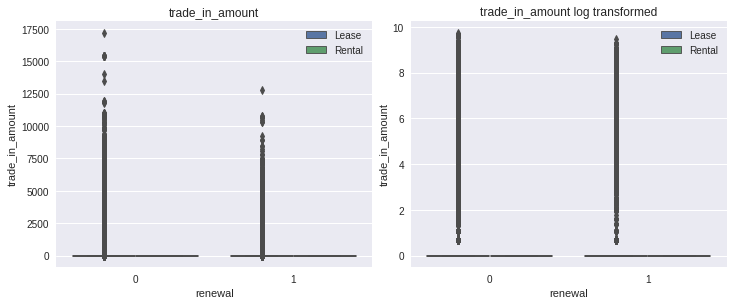

discount_amount_zdv1 ========================


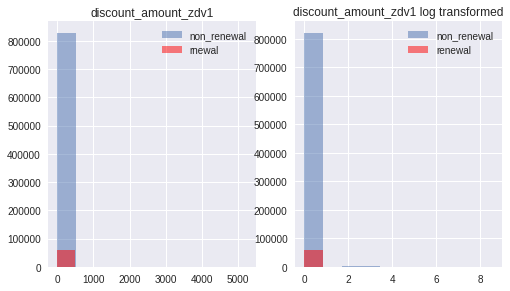

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


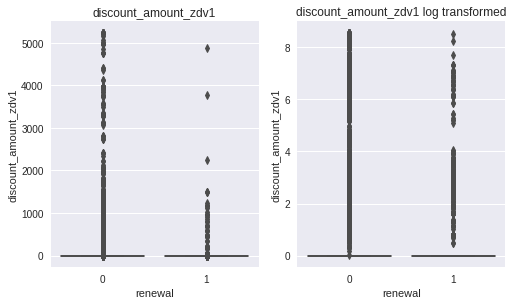

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

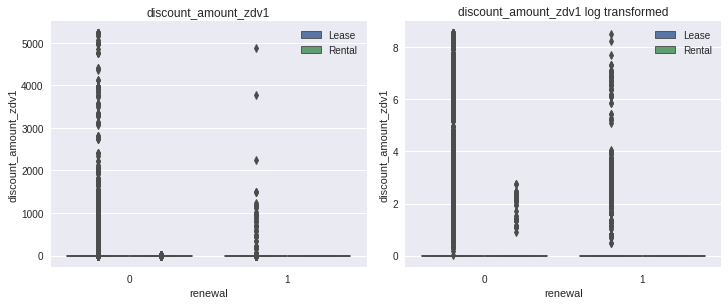

list_minus_ti ========================


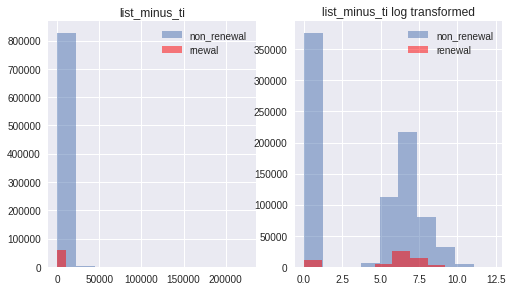

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


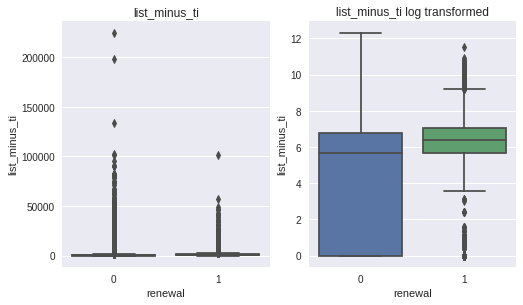

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

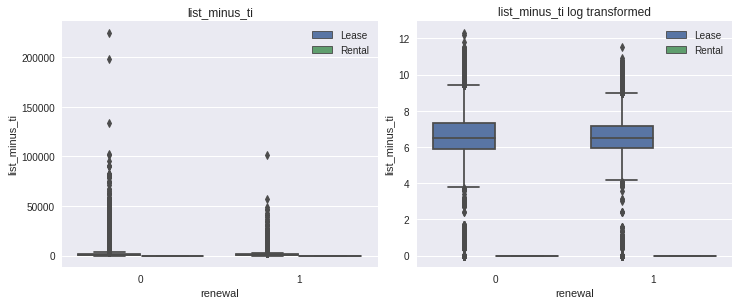

In [26]:
cols=['list_price','trade_in_amount','discount_amount_zdv1', 'list_minus_ti']

corrMatrix = md[cols].corr()
#print (corrMatrix)
sns.heatmap(corrMatrix, annot=True)
plt.show()

print(anova_res_pd[anova_res_pd['variable_name'].isin(cols)])

for i in cols:
    plot_func(i)
    
## tradein amount seems to be most significant
## list_minus_ti -- directionaly intuitive

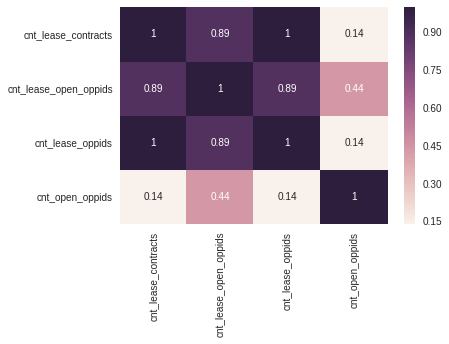

                       anova_p_value  non_ren_mean  ren_mean  non_ren_md  \
cnt_lease_open_oppids   0.000000e+00      0.556965  0.831963         1.0   
cnt_lease_oppids        0.000000e+00      0.612962  0.901325         1.0   
cnt_lease_contracts     0.000000e+00      0.612937  0.901256         1.0   
cnt_open_oppids        2.021202e-181      0.876531  0.917231         1.0   

                       ren_md          variable_name  
cnt_lease_open_oppids     1.0  cnt_lease_open_oppids  
cnt_lease_oppids          1.0       cnt_lease_oppids  
cnt_lease_contracts       1.0    cnt_lease_contracts  
cnt_open_oppids           1.0        cnt_open_oppids  
cnt_lease_contracts ========================


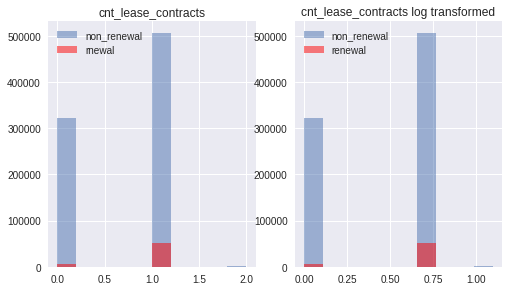

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


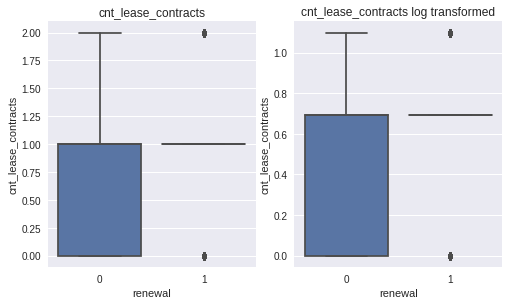

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

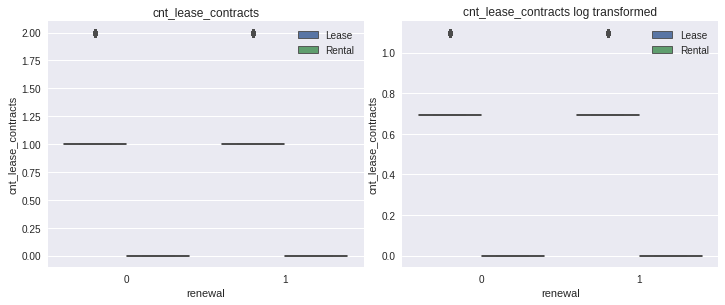

cnt_lease_open_oppids ========================


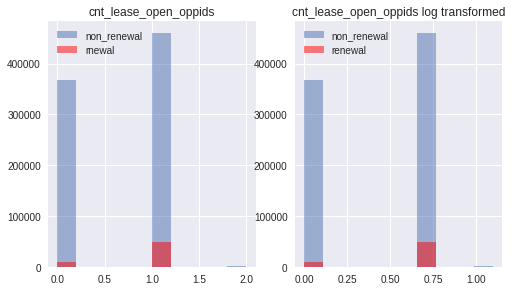

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


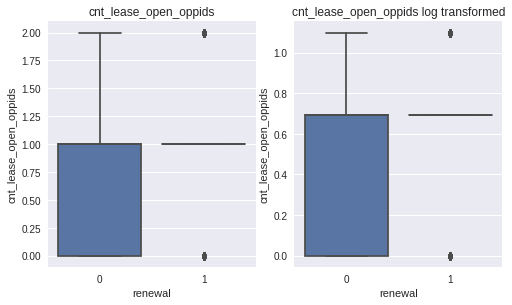

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

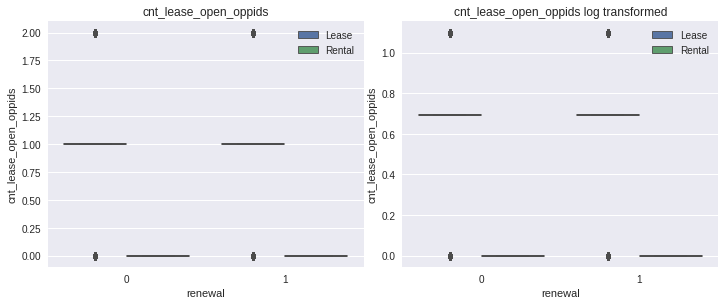

cnt_lease_oppids ========================


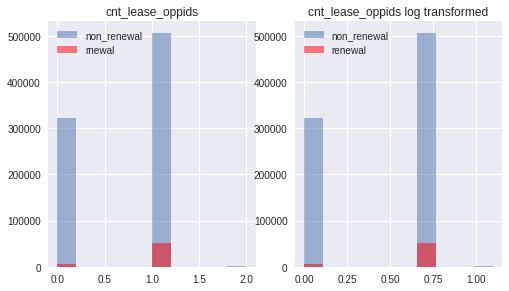

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


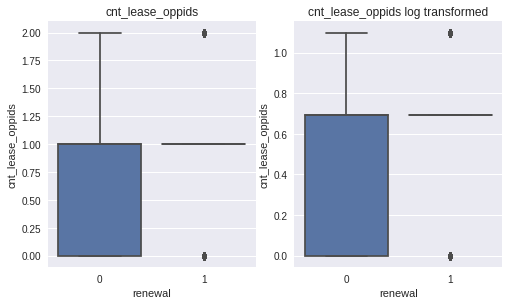

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

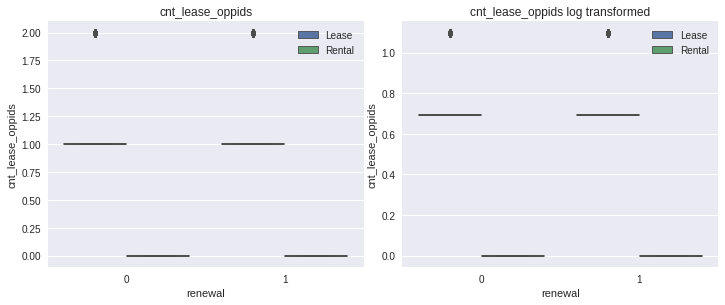

cnt_open_oppids ========================


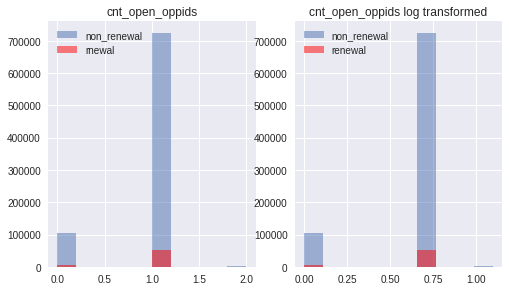

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


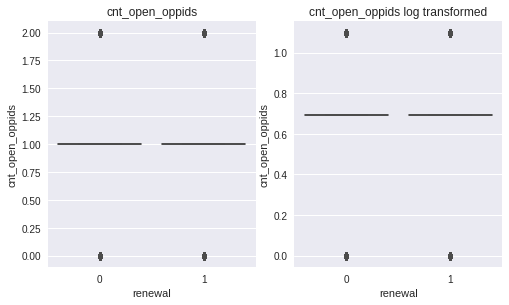

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

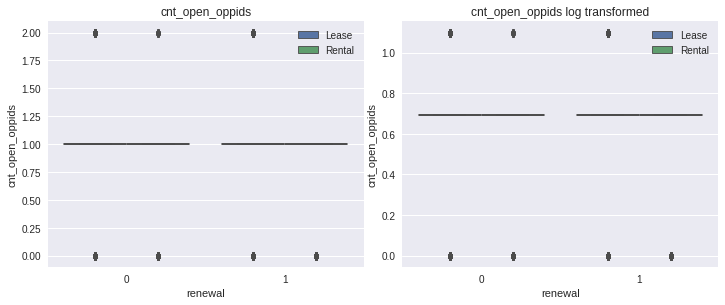

In [27]:
cols=['cnt_lease_contracts','cnt_lease_open_oppids','cnt_lease_oppids','cnt_open_oppids']

corrMatrix = md[cols].corr()
#print (corrMatrix)
sns.heatmap(corrMatrix, annot=True)
plt.show()

print(anova_res_pd[anova_res_pd['variable_name'].isin(cols)])

for i in cols:
    plot_func(i)
    
## cnt_lease_contracts
## cnt_open_oppids

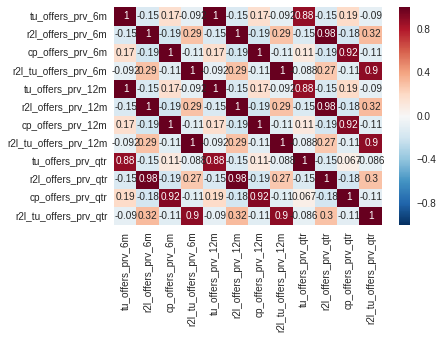

                       anova_p_value  non_ren_mean  ren_mean  non_ren_md  \
r2l_offers_prv_12m      0.000000e+00      1.066382  0.324838         0.0   
cp_offers_prv_6m       2.055855e-133      0.514533  0.652829         0.0   
tu_offers_prv_6m        0.000000e+00      0.783338  1.209688         0.0   
cp_offers_prv_qtr      5.887241e-254      0.295132  0.408382         0.0   
tu_offers_prv_12m       0.000000e+00      0.783338  1.209688         0.0   
tu_offers_prv_qtr      6.795946e-280      0.461541  0.696927         0.0   
r2l_tu_offers_prv_12m   0.000000e+00      0.258935  0.092057         0.0   
cp_offers_prv_12m      2.055855e-133      0.514533  0.652829         0.0   
r2l_offers_prv_qtr      0.000000e+00      0.561902  0.176274         0.0   
r2l_offers_prv_6m       0.000000e+00      1.066382  0.324838         0.0   
r2l_tu_offers_prv_6m    0.000000e+00      0.258935  0.092057         0.0   
r2l_tu_offers_prv_qtr   0.000000e+00      0.167616  0.060780         0.0   

           

In [32]:
# cols=['tot_offers_prv_6m','tu_offers_prv_6m','r2l_offers_prv_6m','cp_offers_prv_6m','r2l_tu_offers_prv_6m']
# cols=['tot_offers_prv_12m','tu_offers_prv_12m','r2l_offers_prv_12m','cp_offers_prv_12m','r2l_tu_offers_prv_12m']
# cols=['tot_offers_prv_qtr','tu_offers_prv_qtr','r2l_offers_prv_qtr','cp_offers_prv_qtr','r2l_tu_offers_prv_qtr']

cols=['tu_offers_prv_6m','r2l_offers_prv_6m','cp_offers_prv_6m','r2l_tu_offers_prv_6m',
      'tu_offers_prv_12m','r2l_offers_prv_12m','cp_offers_prv_12m','r2l_tu_offers_prv_12m',
       'tu_offers_prv_qtr','r2l_offers_prv_qtr','cp_offers_prv_qtr', 'r2l_tu_offers_prv_qtr']

corrMatrix = md[cols].corr()
#print (corrMatrix)
sns.heatmap(corrMatrix, annot=True)
plt.show()

print(anova_res_pd[anova_res_pd['variable_name'].isin(cols)])
# for i in cols:
#     plot_func(i)
# tu_offers_prv_6m,cp_offers_prv_6m 
# tu_offers_prv_12m, cp_offers_prv_12m
# tu_offers_prv_qtr, cp_offers_prv_qtr

## should pass only one of these variables set to model due to correlation
## will include with tu_offers_prv_6m,cp_offers_prv_6m 

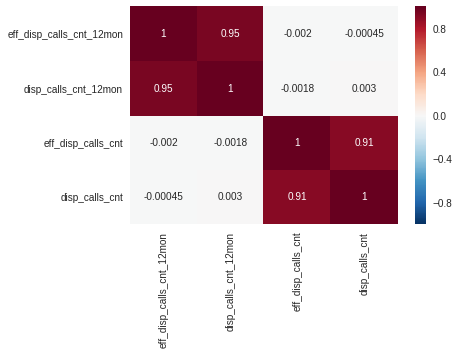

                          anova_p_value  non_ren_mean  ren_mean  non_ren_md  \
disp_calls_cnt             0.000000e+00      0.466845  1.613228         0.0   
disp_calls_cnt_12mon       2.921689e-33      0.195355  0.129384         0.0   
eff_disp_calls_cnt_12mon   7.467028e-35      0.142718  0.090127         0.0   
eff_disp_calls_cnt         0.000000e+00      0.348149  1.434714         0.0   

                          ren_md             variable_name  
disp_calls_cnt               1.0            disp_calls_cnt  
disp_calls_cnt_12mon         0.0      disp_calls_cnt_12mon  
eff_disp_calls_cnt_12mon     0.0  eff_disp_calls_cnt_12mon  
eff_disp_calls_cnt           1.0        eff_disp_calls_cnt  
eff_disp_calls_cnt_12mon ========================


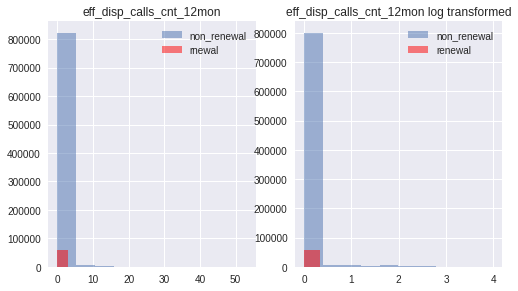

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


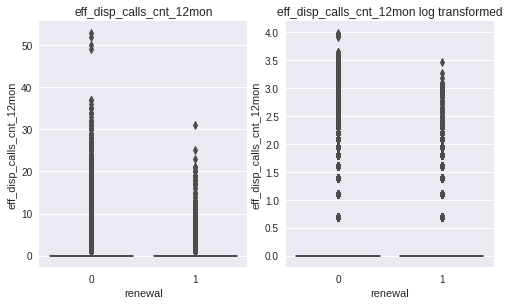

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

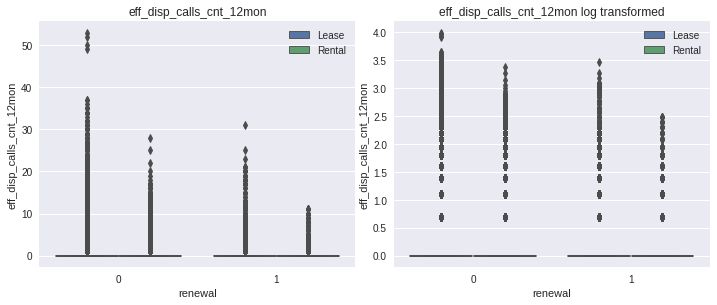

disp_calls_cnt_12mon ========================


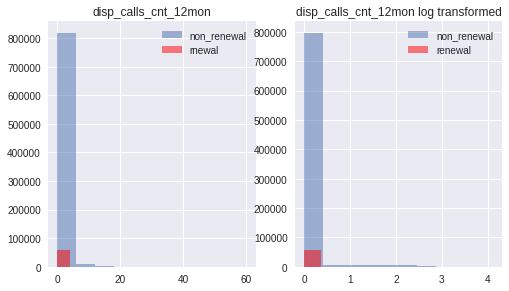

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


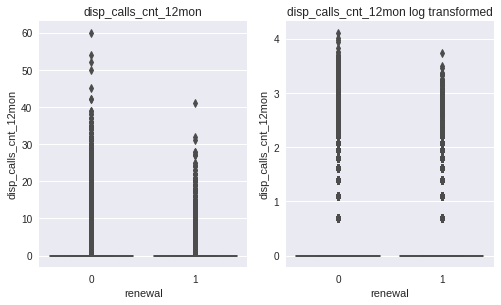

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

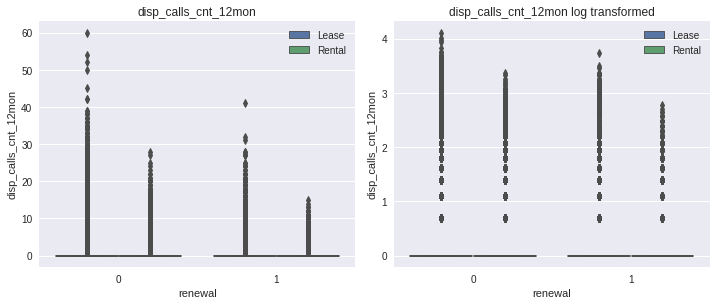

eff_disp_calls_cnt ========================


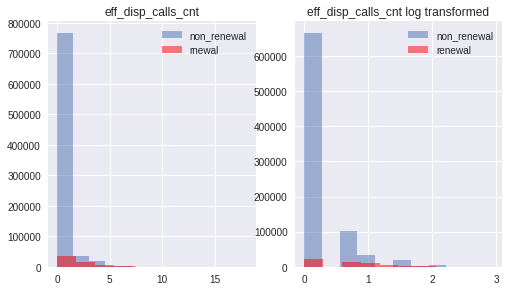

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


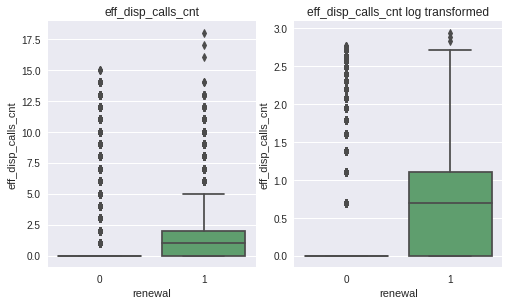

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

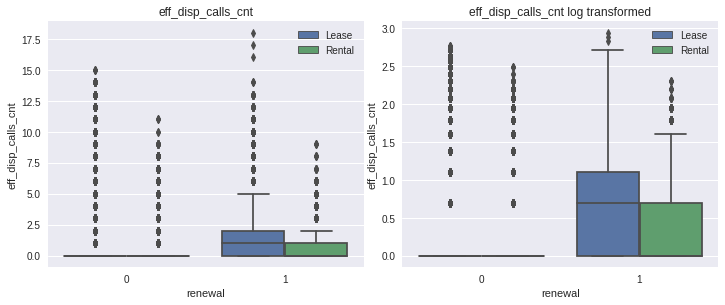

disp_calls_cnt ========================


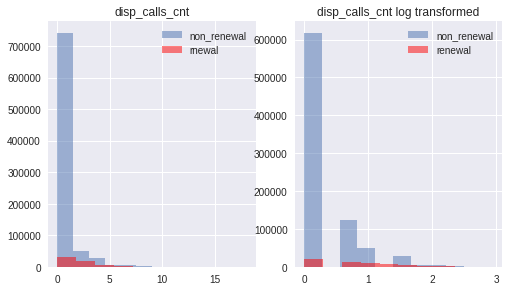

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


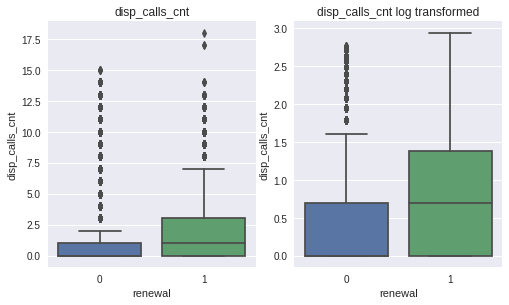

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

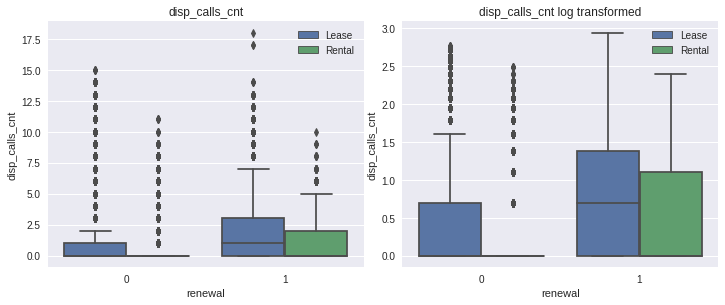

In [33]:
cols=['eff_disp_calls_cnt_12mon','disp_calls_cnt_12mon','eff_disp_calls_cnt','disp_calls_cnt']

corrMatrix = md[cols].corr()
#print (corrMatrix)
sns.heatmap(corrMatrix, annot=True)
plt.show()

print(anova_res_pd[anova_res_pd['variable_name'].isin(cols)])
for i in cols:
    plot_func(i)
## log(disp_calls_cnt),disp_calls_cnt_12mon
## it seems calling too many times has negative impact


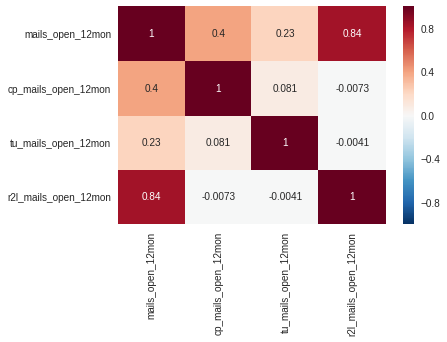

                      anova_p_value  non_ren_mean  ren_mean  non_ren_md  \
r2l_mails_open_12mon   2.901643e-61      0.050844  0.011184         0.0   
tu_mails_open_12mon    1.570545e-05      0.006029  0.008461         0.0   
cp_mails_open_12mon    8.481453e-05      0.021090  0.016957         0.0   
mails_open_12mon       1.273657e-64      0.095426  0.044254         0.0   

                      ren_md         variable_name  
r2l_mails_open_12mon     0.0  r2l_mails_open_12mon  
tu_mails_open_12mon      0.0   tu_mails_open_12mon  
cp_mails_open_12mon      0.0   cp_mails_open_12mon  
mails_open_12mon         0.0      mails_open_12mon  
mails_open_12mon ========================


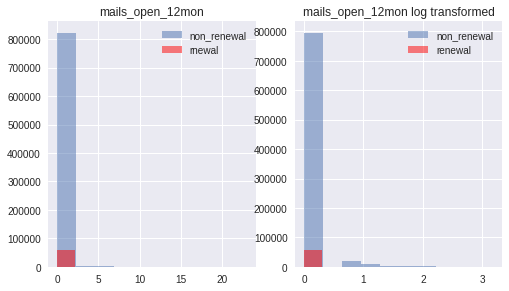

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


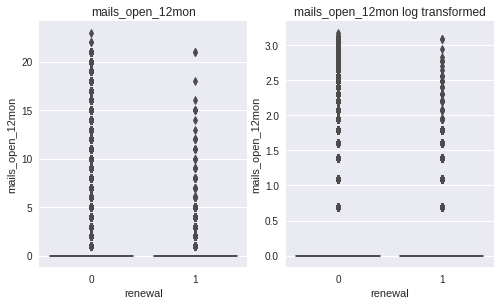

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

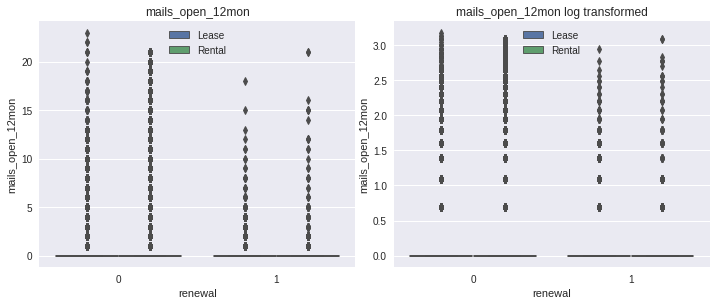

cp_mails_open_12mon ========================


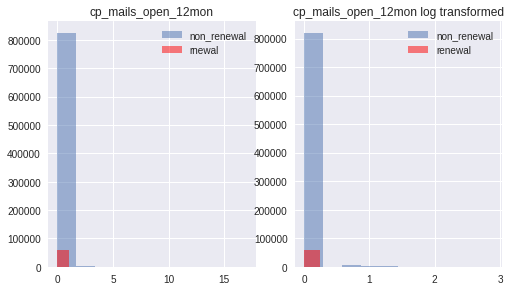

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


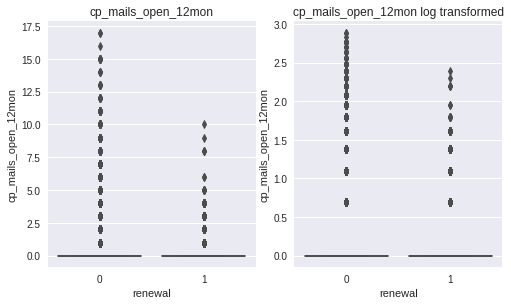

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

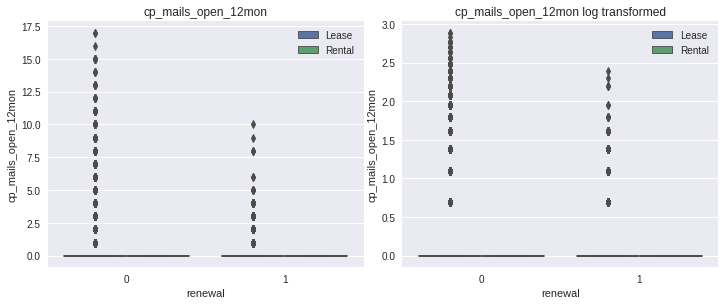

tu_mails_open_12mon ========================


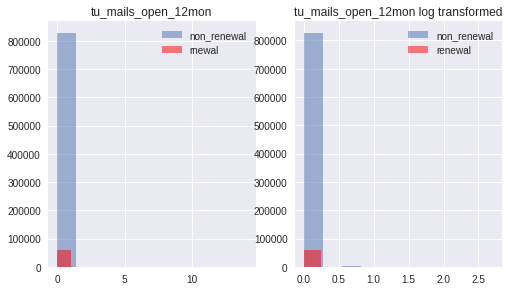

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


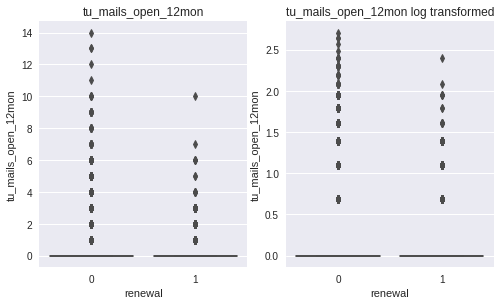

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

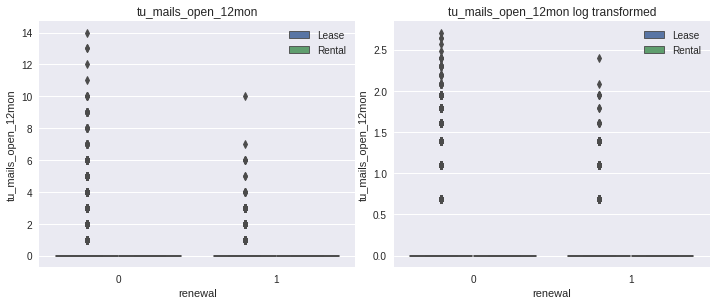

r2l_mails_open_12mon ========================


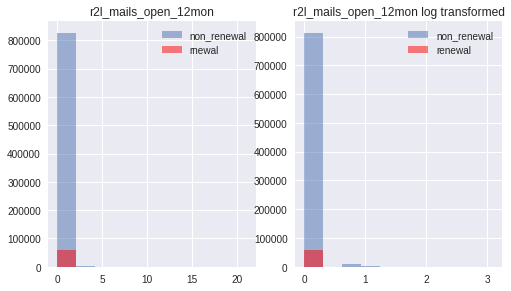

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


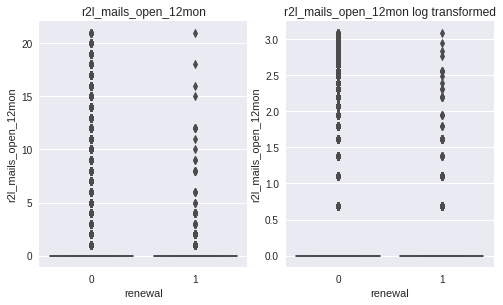

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

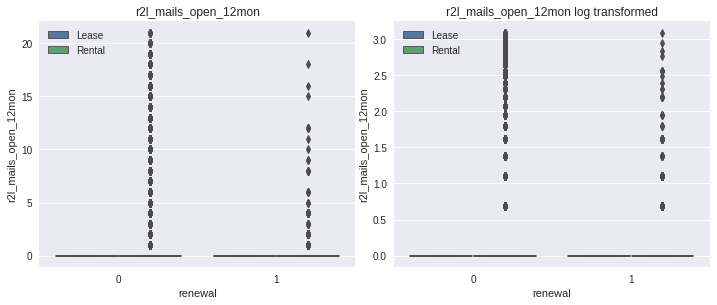

In [18]:
# cols=['mail_sends','cp_mail_sends','tu_mail_sends','r2l_mail_sends']
# cols=['mail_sends_12mon','cp_mail_sends_12mon','tu_mail_sends_12mon','r2l_mail_sends_12mon']
# cols=['mails_clicks_12mon','cp_mails_clicks_12mon','tu_mails_clicks_12mon','r2l_mails_clicks_12mon']
cols=['mails_open_12mon','cp_mails_open_12mon','tu_mails_open_12mon','r2l_mails_open_12mon']

corrMatrix = md[cols].corr()
#print (corrMatrix)
sns.heatmap(corrMatrix, annot=True)
plt.show()

print(anova_res_pd[anova_res_pd['variable_name'].isin(cols)])
for i in cols:
    plot_func(i)
    
# tu_mail_sends,cp_mail_sends,mail_sends (mail_sends is correlated with r2l_mail_sends)
# it seems fr rent to lease-  tto much of mail communication is causing undesirable results
# tu_mail_sends_12mon
# r2l_mails_clicks_12mon,mails_clicks_12mon -- impact is counter intuitive
# mails_open_12mon,r2l_mails_open_12mon -- impact is counter intuitive

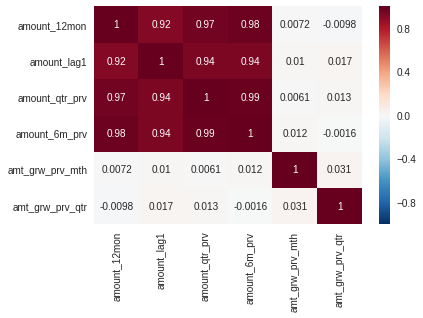

                 anova_p_value  non_ren_mean     ren_mean  non_ren_md  \
amount_qtr_prv        0.717049    615.660129   612.483811      179.93   
amt_grw_prv_qtr       0.391651    280.465712   262.422313        1.00   
amount_12mon          0.812109   2441.985930  2434.362962      762.59   
amt_grw_prv_mth       0.170047      9.696983     4.557415        1.00   
amount_6m_prv         0.449787   1238.079991  1225.177265      373.56   
amount_lag1           0.340688    204.024320   200.814587       55.75   

                      ren_md    variable_name  
amount_qtr_prv    312.500000   amount_qtr_prv  
amt_grw_prv_qtr     0.989176  amt_grw_prv_qtr  
amount_12mon     1286.350000     amount_12mon  
amt_grw_prv_mth     0.993838  amt_grw_prv_mth  
amount_6m_prv     642.890000    amount_6m_prv  
amount_lag1        96.900000      amount_lag1  
amount_12mon ========================


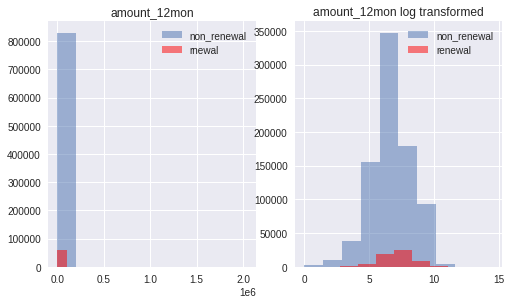

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


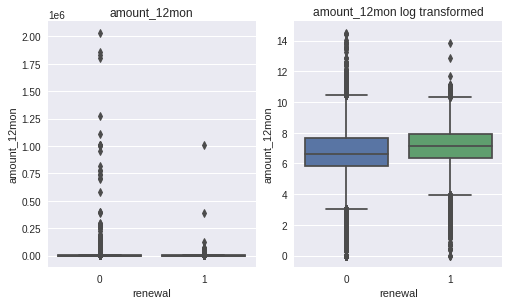

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

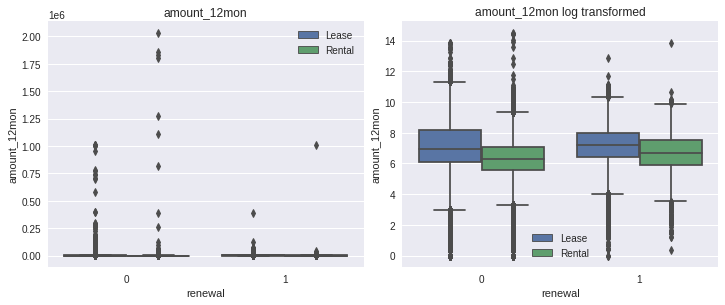

amount_lag1 ========================


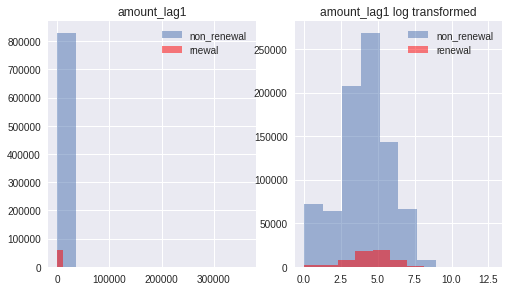

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


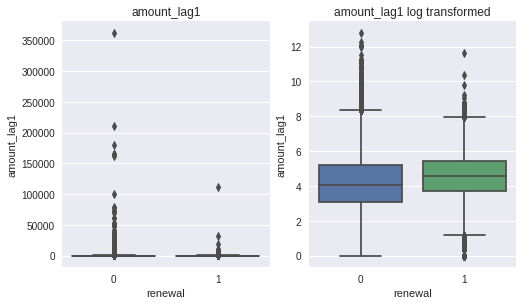

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

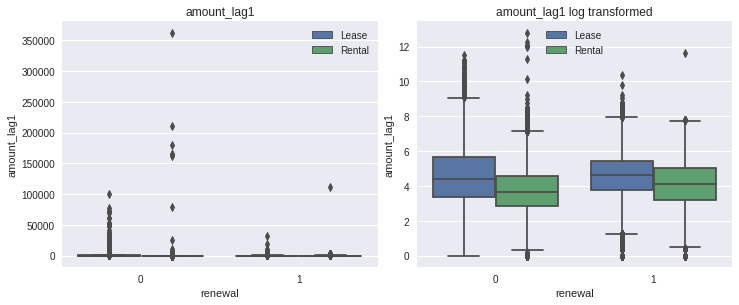

amount_qtr_prv ========================


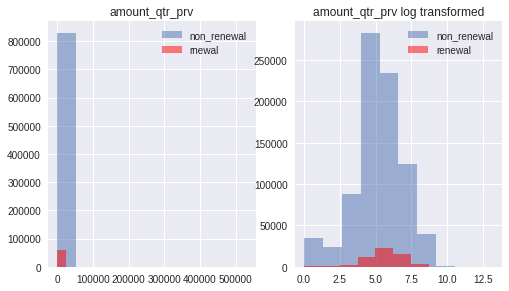

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


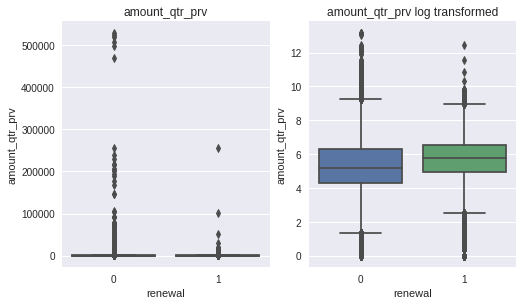

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

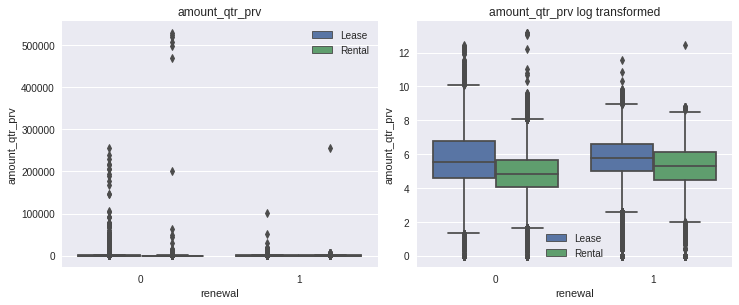

amount_6m_prv ========================


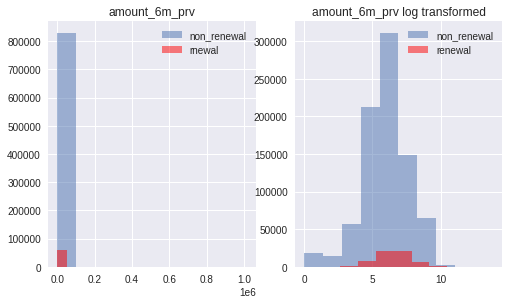

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


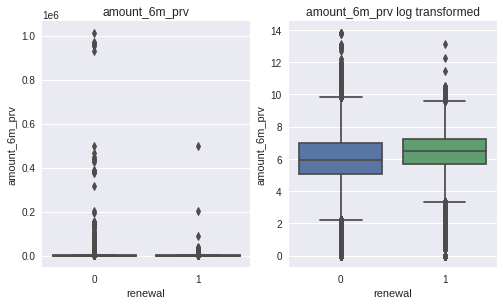

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

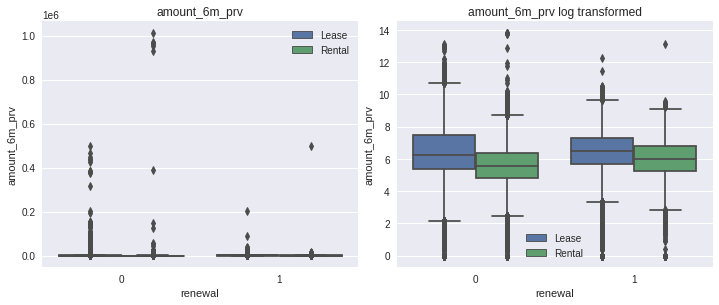

amt_grw_prv_mth ========================


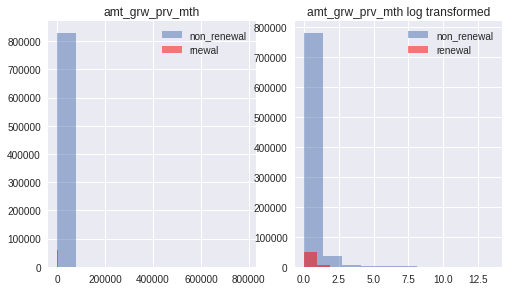

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


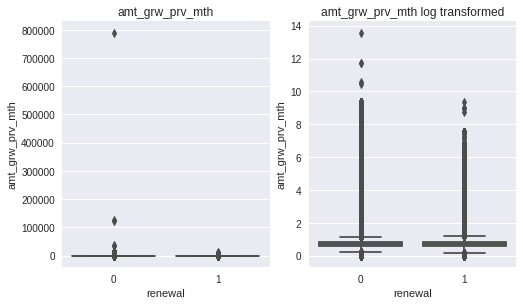

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

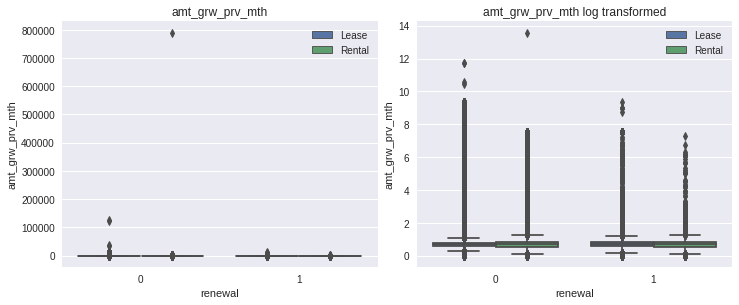

amt_grw_prv_qtr ========================


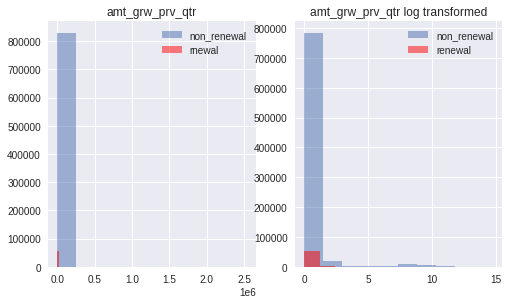

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


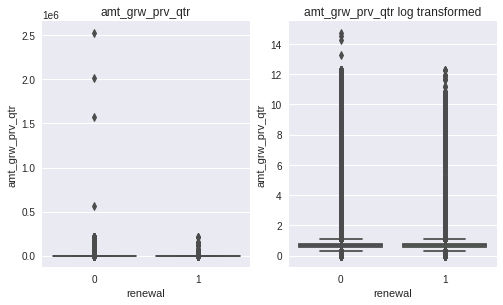

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

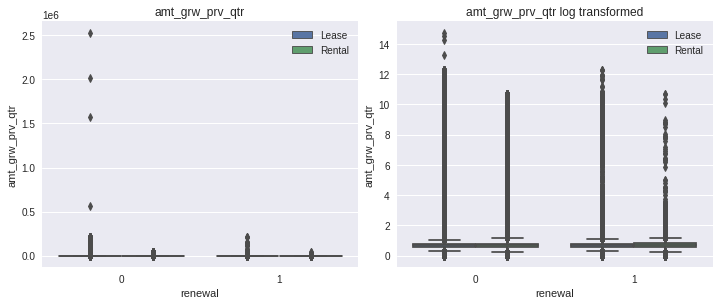

In [19]:
cols=['amount_12mon','amount_lag1','amount_qtr_prv','amount_6m_prv','amt_grw_prv_mth','amt_grw_prv_qtr']

corrMatrix = md[cols].corr()
#print (corrMatrix)
sns.heatmap(corrMatrix, annot=True)
plt.show()

print(anova_res_pd[anova_res_pd['variable_name'].isin(cols)])
for i in cols:
     #print(md[i].describe
    plot_func(i)
# amount_6m_prv, amt_grw_prv_mth might be useful

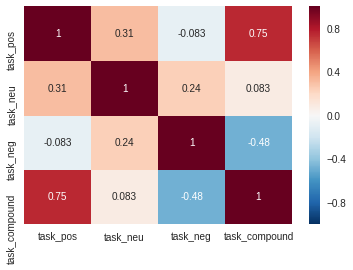

               anova_p_value  non_ren_mean  ren_mean  non_ren_md  ren_md  \
task_compound   1.948386e-16      0.096951  0.079085       0.000   0.000   
task_neu        1.105408e-06      0.625740  0.634263       0.834   0.849   
task_pos        9.224258e-78      0.047451  0.041727       0.000   0.000   
task_neg        8.342151e-10      0.037075  0.035289       0.000   0.000   

               variable_name  
task_compound  task_compound  
task_neu            task_neu  
task_pos            task_pos  
task_neg            task_neg  
task_pos ========================


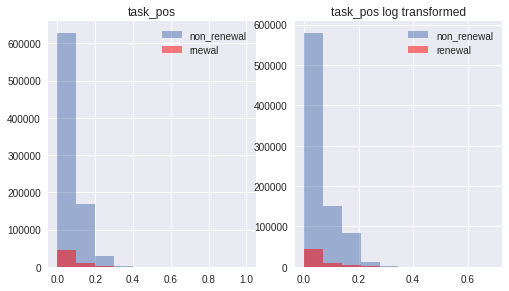

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


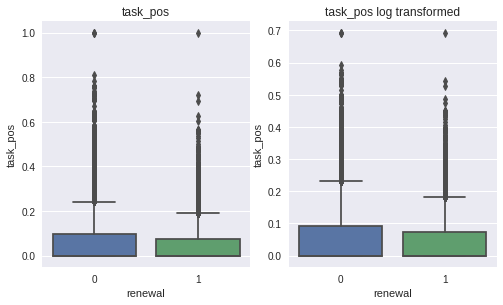

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

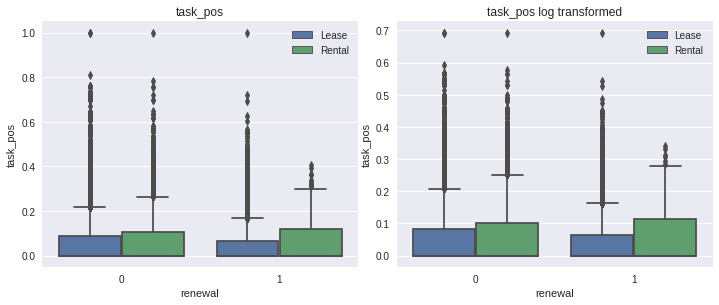

task_neu ========================


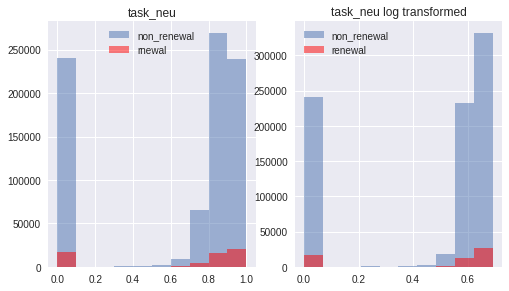

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


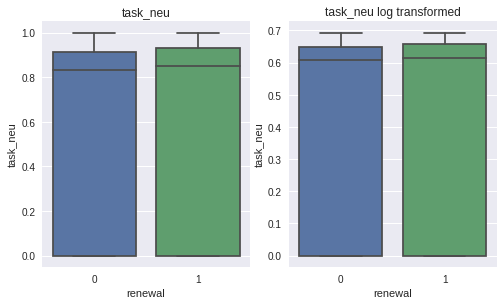

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

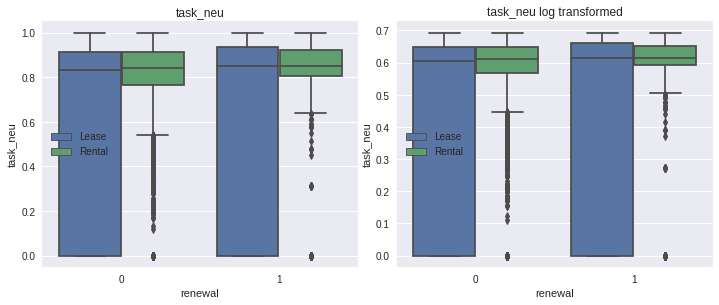

task_neg ========================


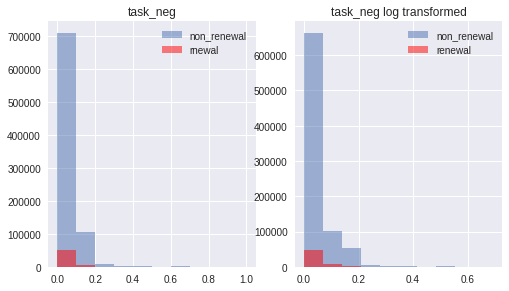

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


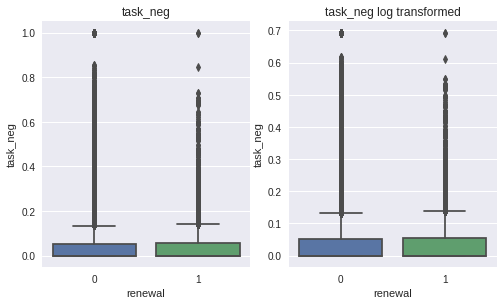

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

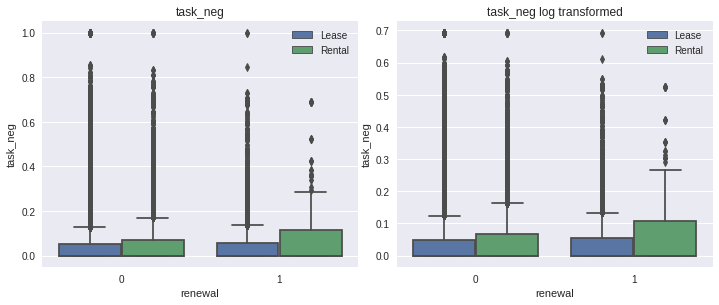

task_compound ========================


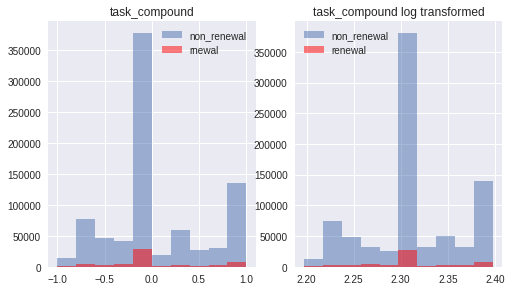

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


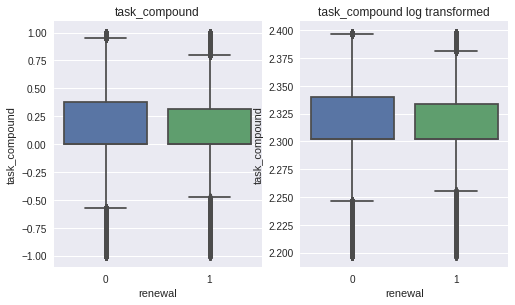

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

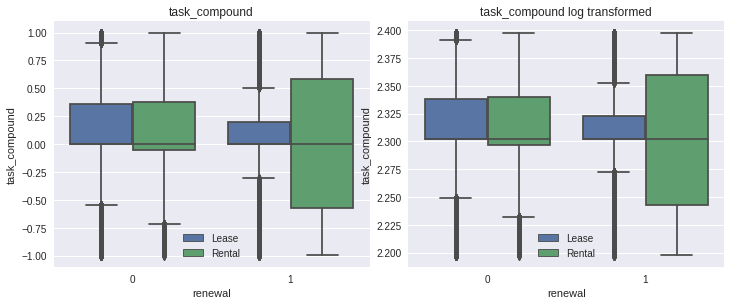

In [24]:
cols=['task_pos','task_neu','task_neg','task_compound']
# cols=['survey_pos','survey_neu','survey_neg','survey_compound']
# cols=['case_pos','case_neu','case_neg','case_compound']

corrMatrix = md[cols].corr()
#print (corrMatrix)
sns.heatmap(corrMatrix, annot=True)
plt.show()

print(anova_res_pd[anova_res_pd['variable_name'].isin(cols)])
for i in cols:
     #print(md[i].describe
    
    if re.search('compound',i):
        plot_func(i,log_add=10) 
    else:
        plot_func(i)
# task_pos,task_compound, task_neg 
# case_compound, case_neu

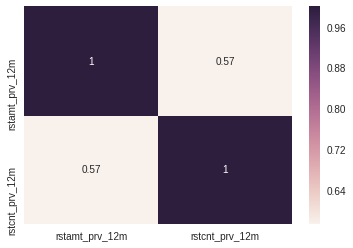

                anova_p_value  non_ren_mean    ren_mean  non_ren_md  ren_md  \
rstcnt_prv_12m   1.770772e-08      1.256674    1.341460         1.0     1.0   
rstamt_prv_12m   1.879847e-04    495.566526  459.782523       100.0   200.0   

                 variable_name  
rstcnt_prv_12m  rstcnt_prv_12m  
rstamt_prv_12m  rstamt_prv_12m  
rstamt_prv_12m ========================


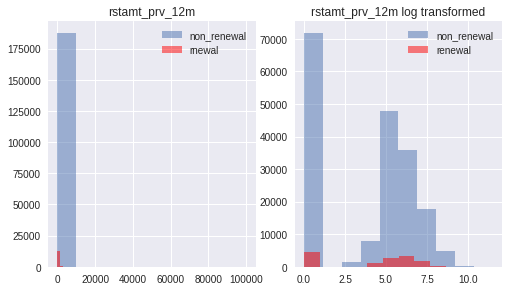

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


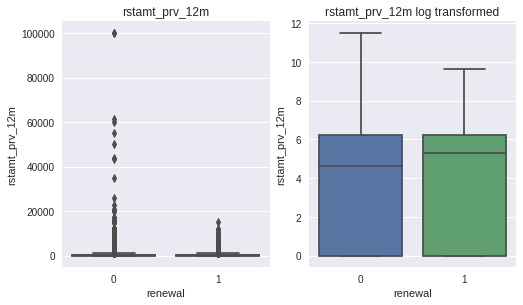

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

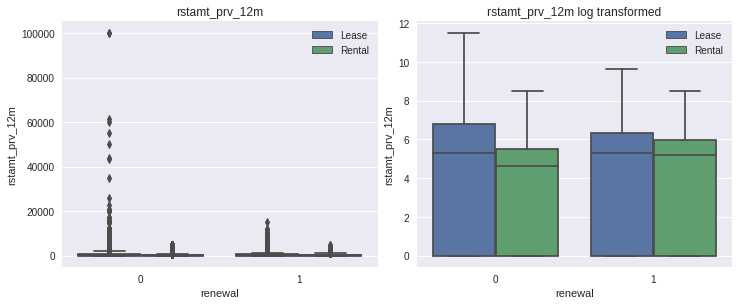

rstcnt_prv_12m ========================


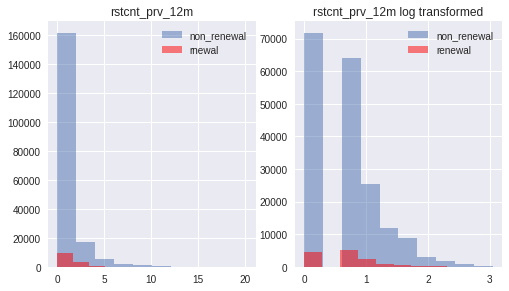

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


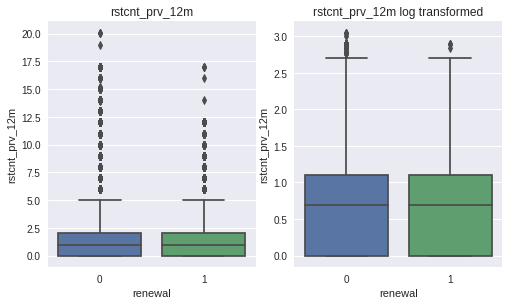

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

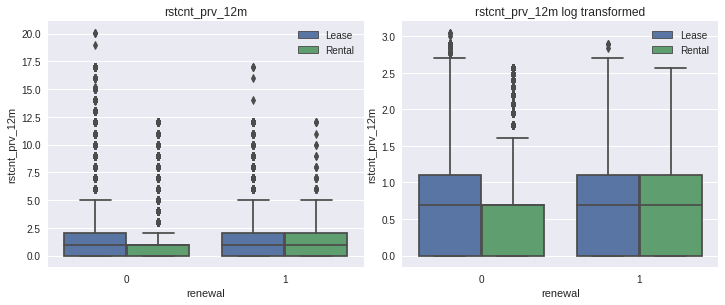

In [65]:
cols=['rstamt_prv_12m','rstcnt_prv_12m']

corrMatrix = md[cols].corr()
#print (corrMatrix)
sns.heatmap(corrMatrix, annot=True)
plt.show()

print(anova_res_pd[anova_res_pd['variable_name'].isin(cols)])
for i in cols:
    #print(md[i].describe
    plot_func(i) 

# rstamt_prv_12m -- changing missing value imputation by zero can add more value

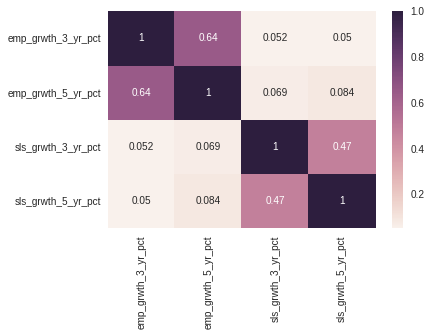

                    anova_p_value  non_ren_mean  ren_mean  non_ren_md  ren_md  \
sls_grwth_5_yr_pct   2.867994e-07      1.811944  2.370435         0.0     0.0   
emp_grwth_3_yr_pct   6.088561e-01      3.695692  3.603664         0.0     0.0   
sls_grwth_3_yr_pct   1.671747e-06      1.176621  1.569129         0.0     0.0   
emp_grwth_5_yr_pct   3.420918e-01      5.893199  6.105689         0.0     0.0   

                         variable_name  
sls_grwth_5_yr_pct  sls_grwth_5_yr_pct  
emp_grwth_3_yr_pct  emp_grwth_3_yr_pct  
sls_grwth_3_yr_pct  sls_grwth_3_yr_pct  
emp_grwth_5_yr_pct  emp_grwth_5_yr_pct  
emp_grwth_3_yr_pct ========================


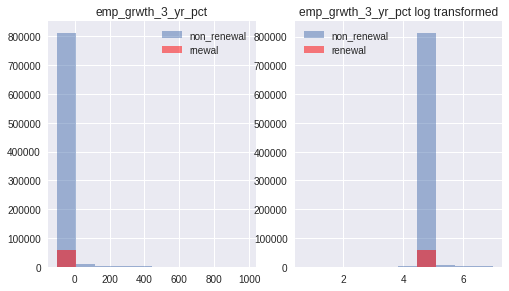

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


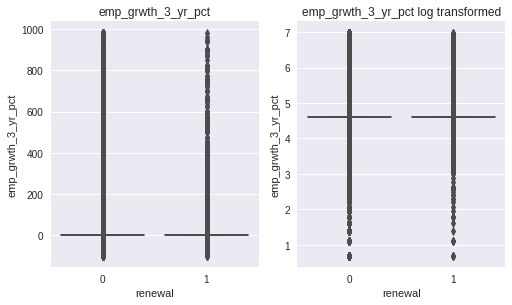

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

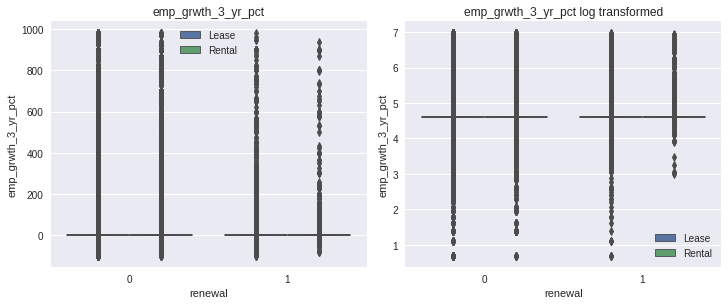

emp_grwth_5_yr_pct ========================


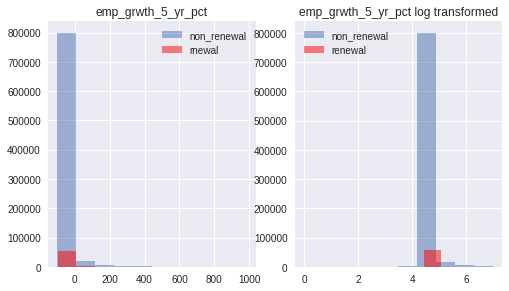

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


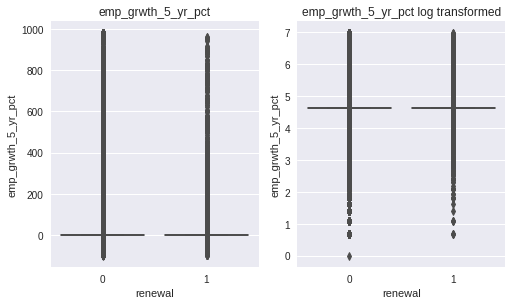

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

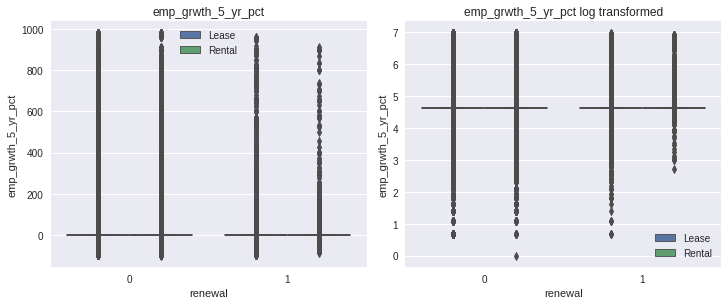

sls_grwth_3_yr_pct ========================


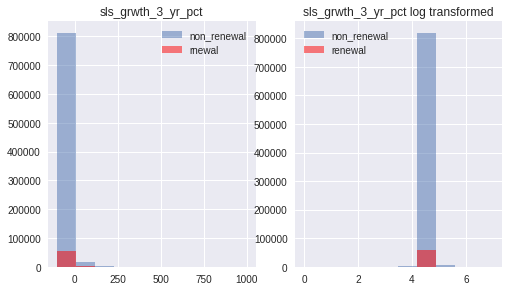

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


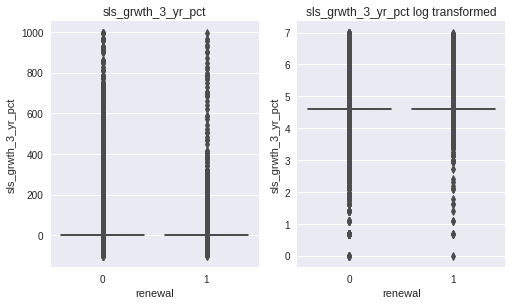

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

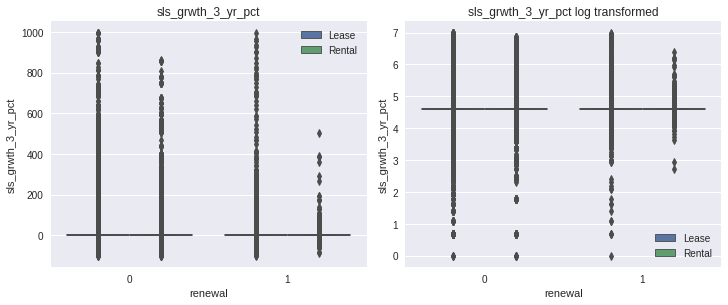

sls_grwth_5_yr_pct ========================


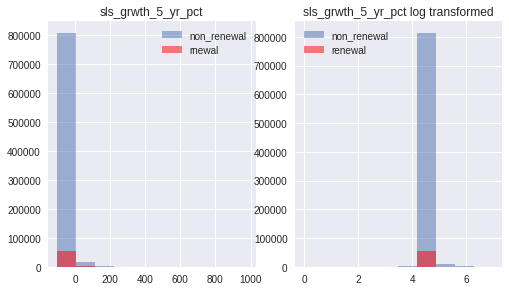

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


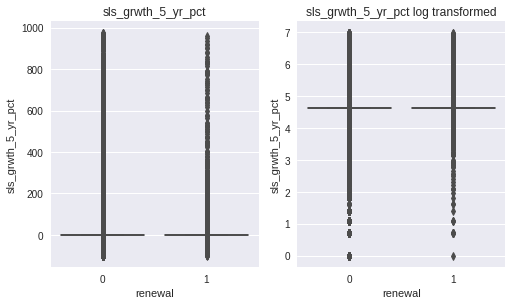

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

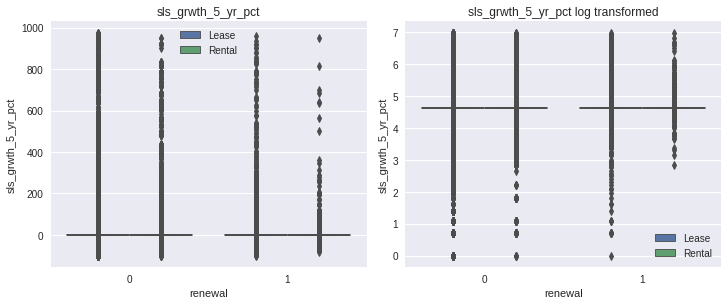

In [23]:
cols=['emp_grwth_3_yr_pct','emp_grwth_5_yr_pct','sls_grwth_3_yr_pct','sls_grwth_5_yr_pct']

corrMatrix = md[cols].corr()
#print (corrMatrix)
sns.heatmap(corrMatrix, annot=True)
plt.show()

print(anova_res_pd[anova_res_pd['variable_name'].isin(cols)])
for i in cols:
#     print(md[i].describe())
    plot_func(i,log_add=101)
    
## sls_grwth_5_yr_pct

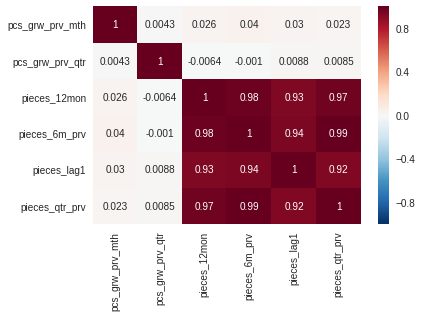

                 anova_p_value  non_ren_mean     ren_mean   non_ren_md  \
pcs_grw_prv_mth       0.644610     18.411541     5.560718     1.000000   
pcs_grw_prv_qtr       0.410356    406.246884   380.402812     0.992282   
pieces_lag1           0.042850    310.486119   291.750069    82.000000   
pieces_6m_prv         0.007225   1889.353433  1783.551341   549.000000   
pieces_12mon          0.013879   3751.187168  3569.448274  1124.000000   
pieces_qtr_prv        0.018495    936.206746   889.417333   266.000000   

                      ren_md    variable_name  
pcs_grw_prv_mth     0.993442  pcs_grw_prv_mth  
pcs_grw_prv_qtr     0.981640  pcs_grw_prv_qtr  
pieces_lag1       144.000000      pieces_lag1  
pieces_6m_prv     951.000000    pieces_6m_prv  
pieces_12mon     1913.000000     pieces_12mon  
pieces_qtr_prv    465.000000   pieces_qtr_prv  
pcs_grw_prv_mth ========================


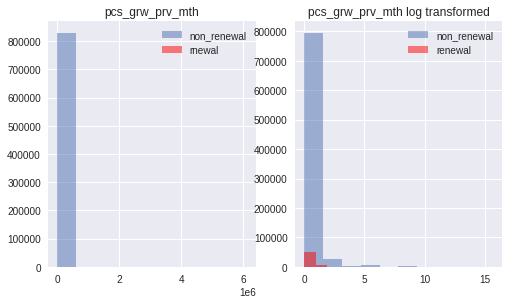

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


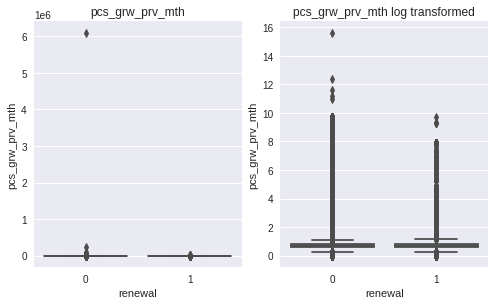

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

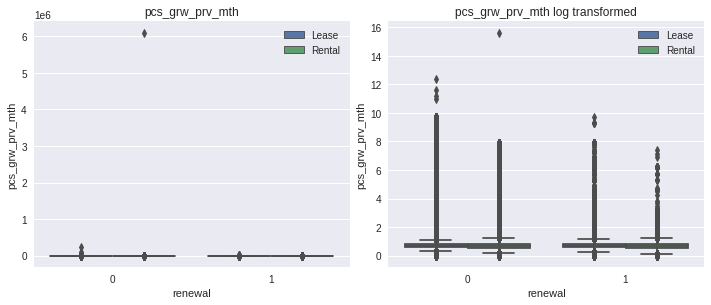

pcs_grw_prv_qtr ========================


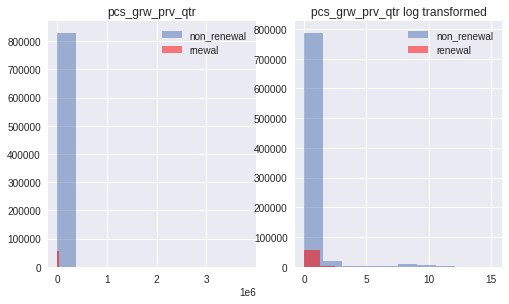

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


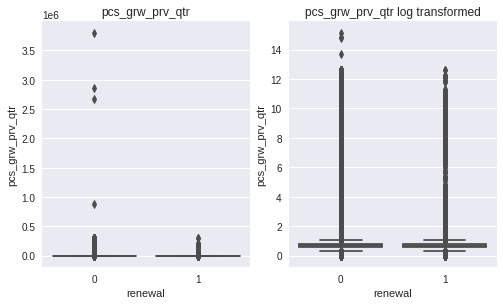

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

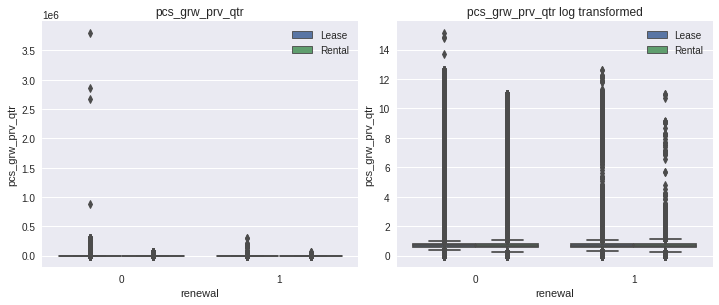

pieces_12mon ========================


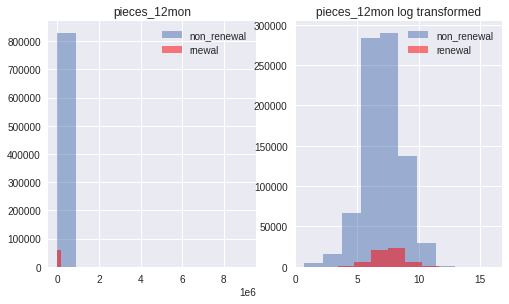

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


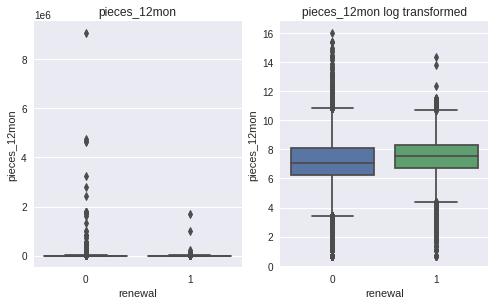

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

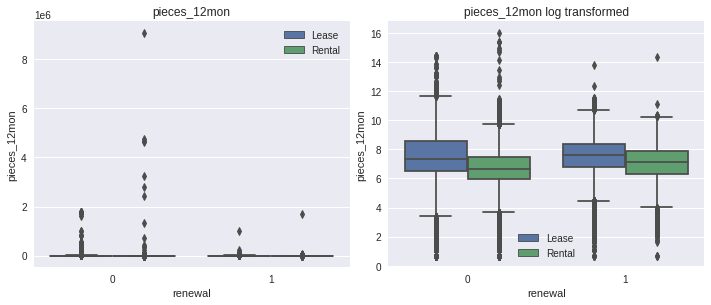

pieces_6m_prv ========================


/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


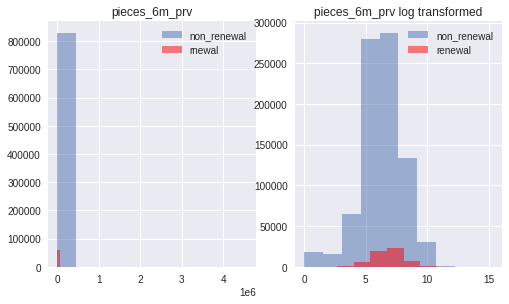

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


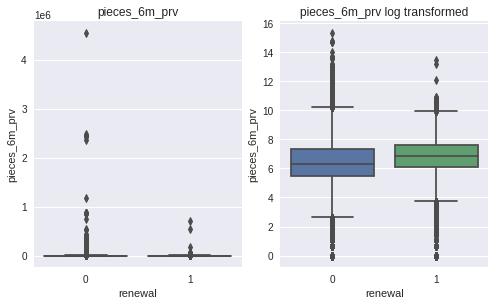

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: Futur

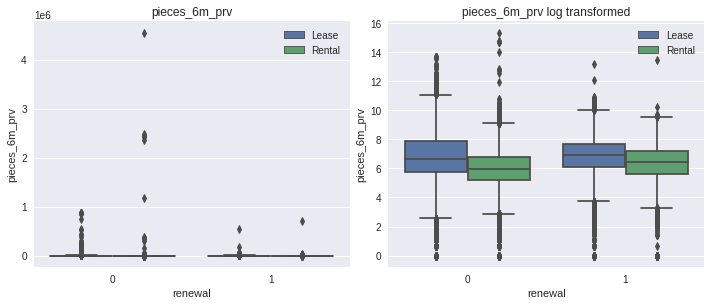

pieces_lag1 ========================


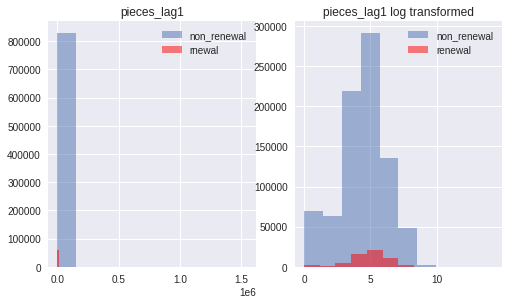

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


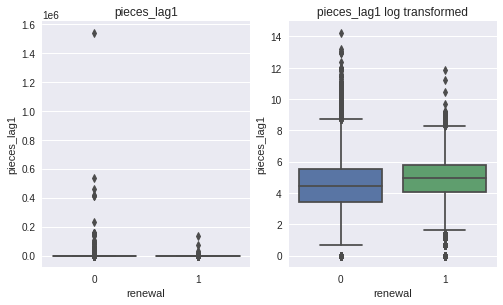

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

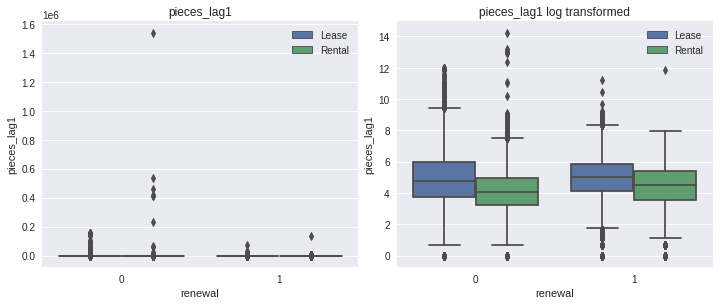

pieces_qtr_prv ========================


/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


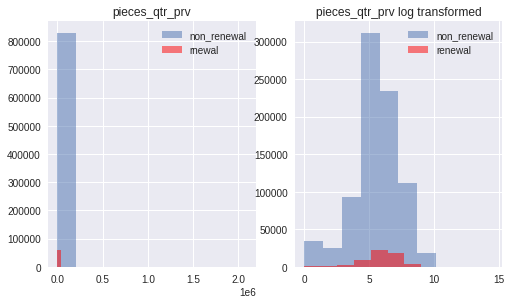

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


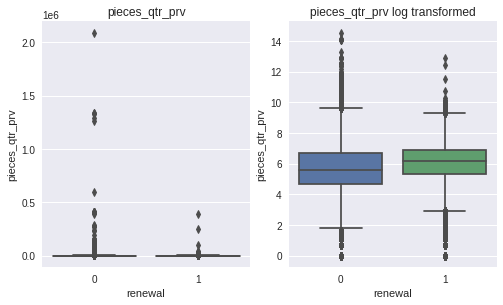

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: Futur

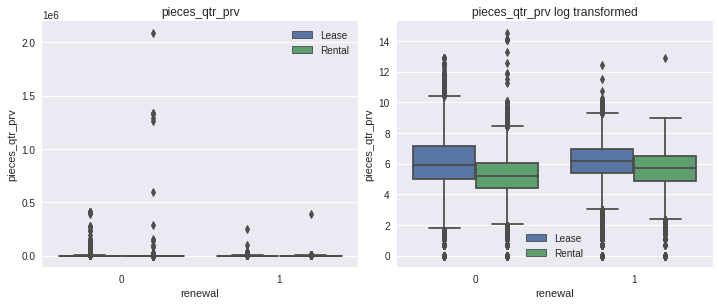

In [25]:
cols=['pcs_grw_prv_mth','pcs_grw_prv_qtr','pieces_12mon','pieces_6m_prv','pieces_lag1','pieces_qtr_prv']

corrMatrix = md[cols].corr()
#print (corrMatrix)
sns.heatmap(corrMatrix, annot=True)
plt.show()

print(anova_res_pd[anova_res_pd['variable_name'].isin(cols)])
for i in cols:
     #print(md[i].describe
    plot_func(i)

# pieces_6m_prv

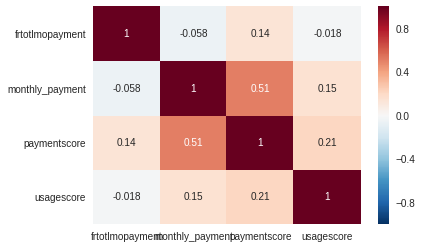

                 anova_p_value  non_ren_mean      ren_mean   non_ren_md  \
usagescore        0.000000e+00  6.013859e+00  7.051423e+00     4.000000   
paymentscore      0.000000e+00  5.961582e+00  7.394217e+00     5.000000   
frtotlmopayment   3.152263e-01  1.072935e+16  1.064096e+16  1895.000000   
monthly_payment   7.211578e-12  5.612097e+01  5.426633e+01    38.333333   

                 ren_md    variable_name  
usagescore          8.0       usagescore  
paymentscore       10.0     paymentscore  
frtotlmopayment   222.0  frtotlmopayment  
monthly_payment    43.0  monthly_payment  
frtotlmopayment ========================


/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


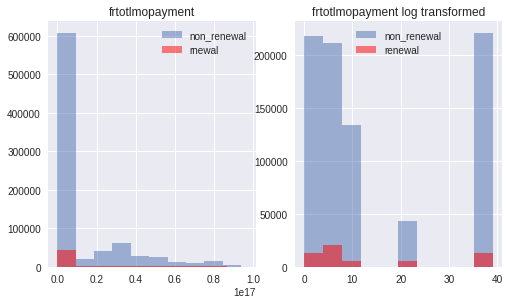

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


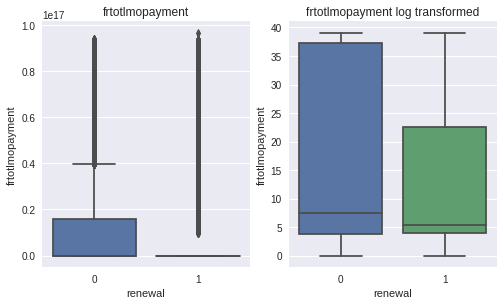

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: Futur

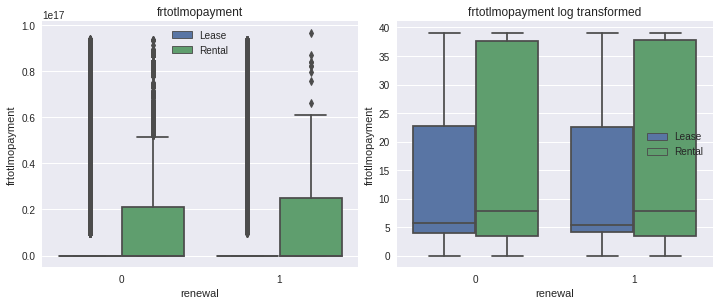

monthly_payment ========================


/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


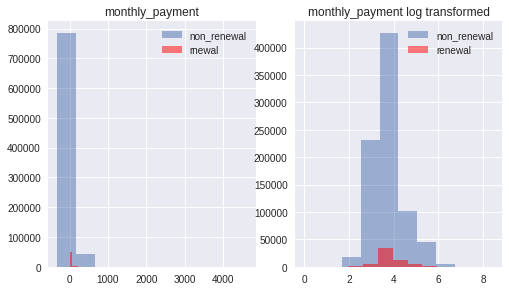

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


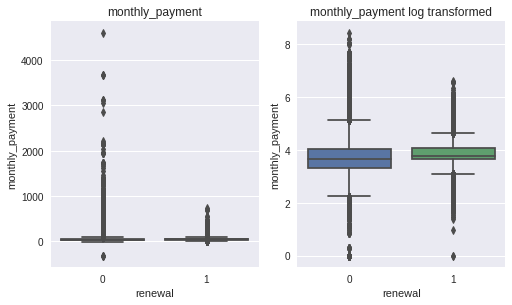

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: Futur

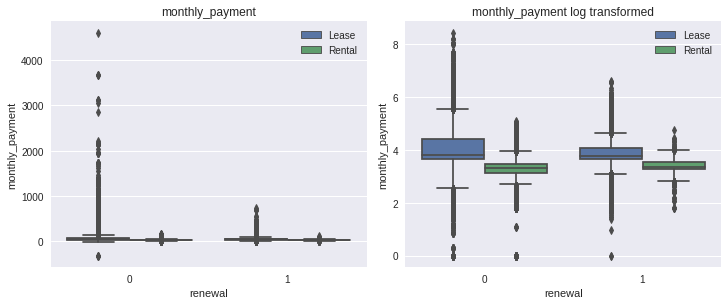

paymentscore ========================


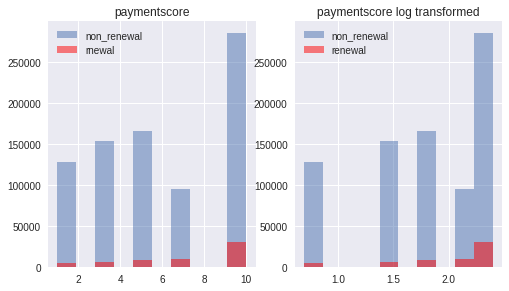

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


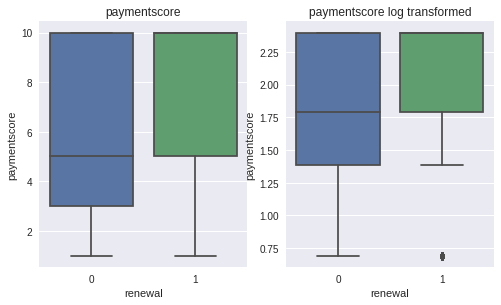

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

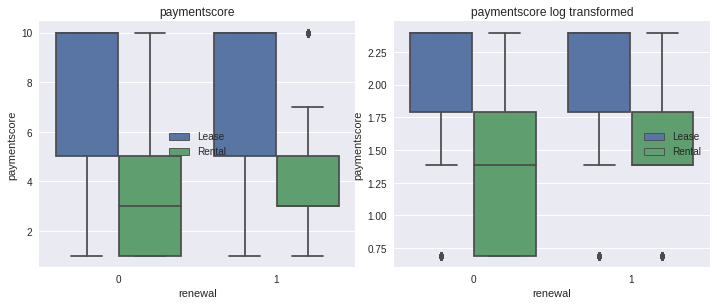

usagescore ========================


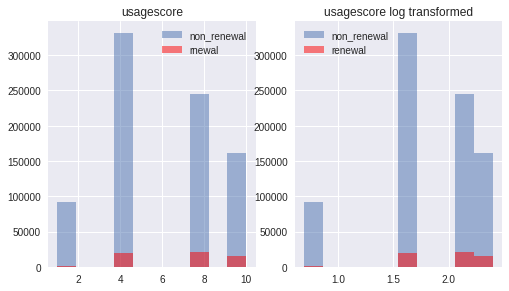

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


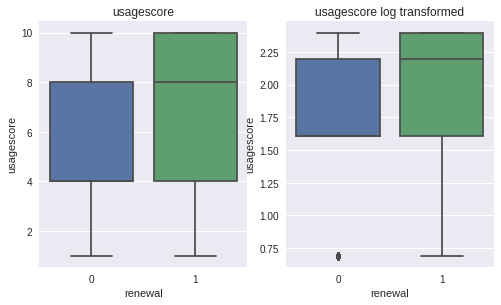

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

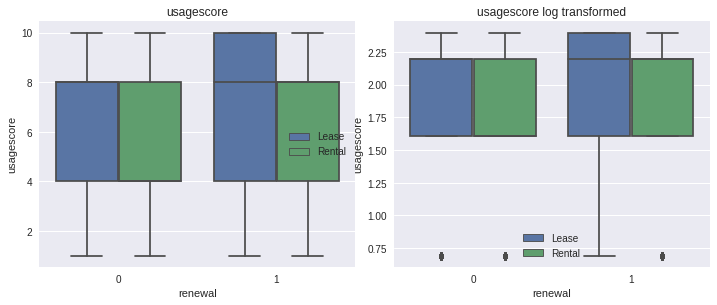

In [26]:
cols=['frtotlmopayment','monthly_payment','paymentscore','usagescore']

corrMatrix = md[cols].corr()
#print (corrMatrix)
sns.heatmap(corrMatrix, annot=True)
plt.show()

print(anova_res_pd[anova_res_pd['variable_name'].isin(cols)])
for i in cols:
     #print(md[i].describe
    plot_func(i)
    
# monthly_payment,usagescore

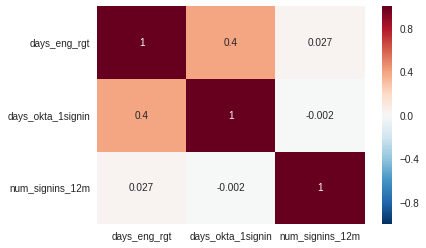

                   anova_p_value  non_ren_mean    ren_mean  non_ren_md  \
num_signins_12m     1.495314e-04      6.448490    6.589877         2.0   
days_eng_rgt        2.323046e-61    763.920748  731.396505       801.0   
days_okta_1signin  3.604894e-273    752.369819  703.772453       747.0   

                   ren_md      variable_name  
num_signins_12m       3.0    num_signins_12m  
days_eng_rgt        729.0       days_eng_rgt  
days_okta_1signin   721.0  days_okta_1signin  
count    722223.000000
mean        761.769046
std         415.717900
min           1.000000
25%         399.000000
50%         796.000000
75%        1122.000000
max        1398.000000
Name: days_eng_rgt, dtype: float64
days_eng_rgt ========================


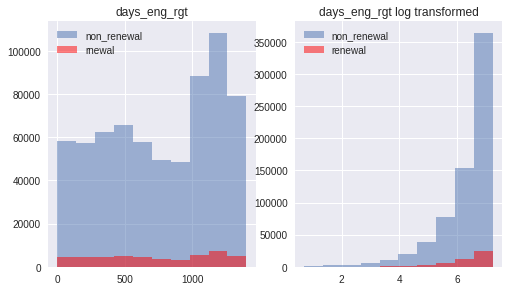

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


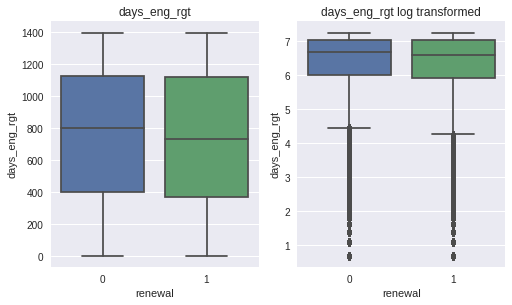

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

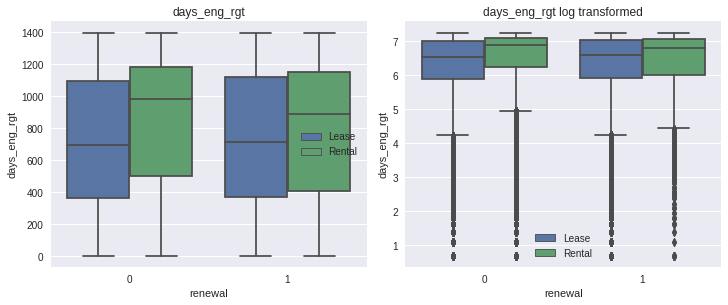

count    804733.000000
mean        749.273472
std         301.636953
min           0.000000
25%         589.000000
50%         746.000000
75%         902.000000
max        1492.000000
Name: days_okta_1signin, dtype: float64
days_okta_1signin ========================


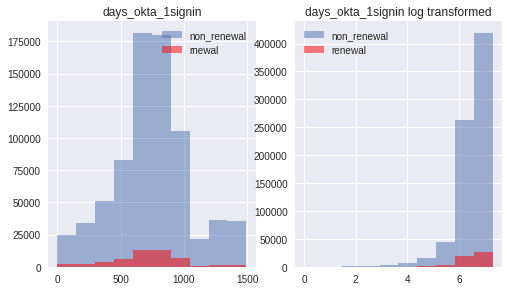

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


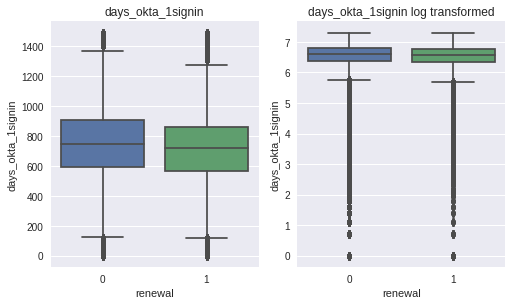

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

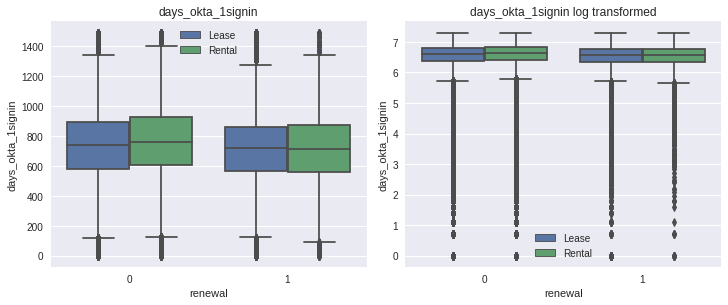

count    886720.000000
mean          6.457743
std           8.683320
min           0.000000
25%           0.000000
50%           2.000000
75%           9.000000
max          30.000000
Name: num_signins_12m, dtype: float64
num_signins_12m ========================


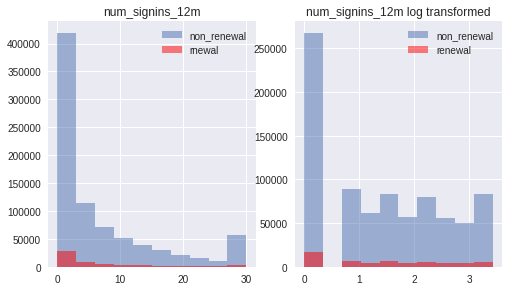

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


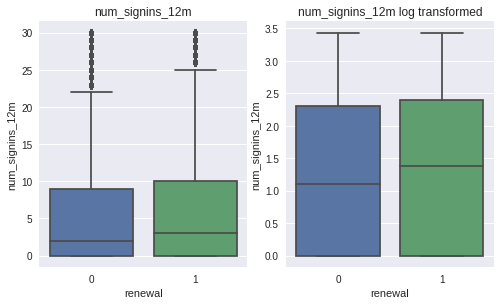

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/cat

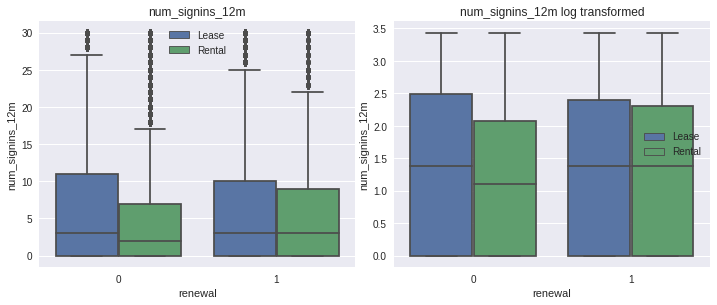

In [27]:
cols=['days_eng_rgt','days_okta_1signin','num_signins_12m']

corrMatrix = md[cols].corr()
#print (corrMatrix)
sns.heatmap(corrMatrix, annot=True)
plt.show()

print(anova_res_pd[anova_res_pd['variable_name'].isin(cols)])
for i in cols:
    print(md[i].describe())
    plot_func(i)

#days_okta_1signin,days_eng_rgt, num_signins_12m
# visually num_signins_12m seems more beneficial

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


27


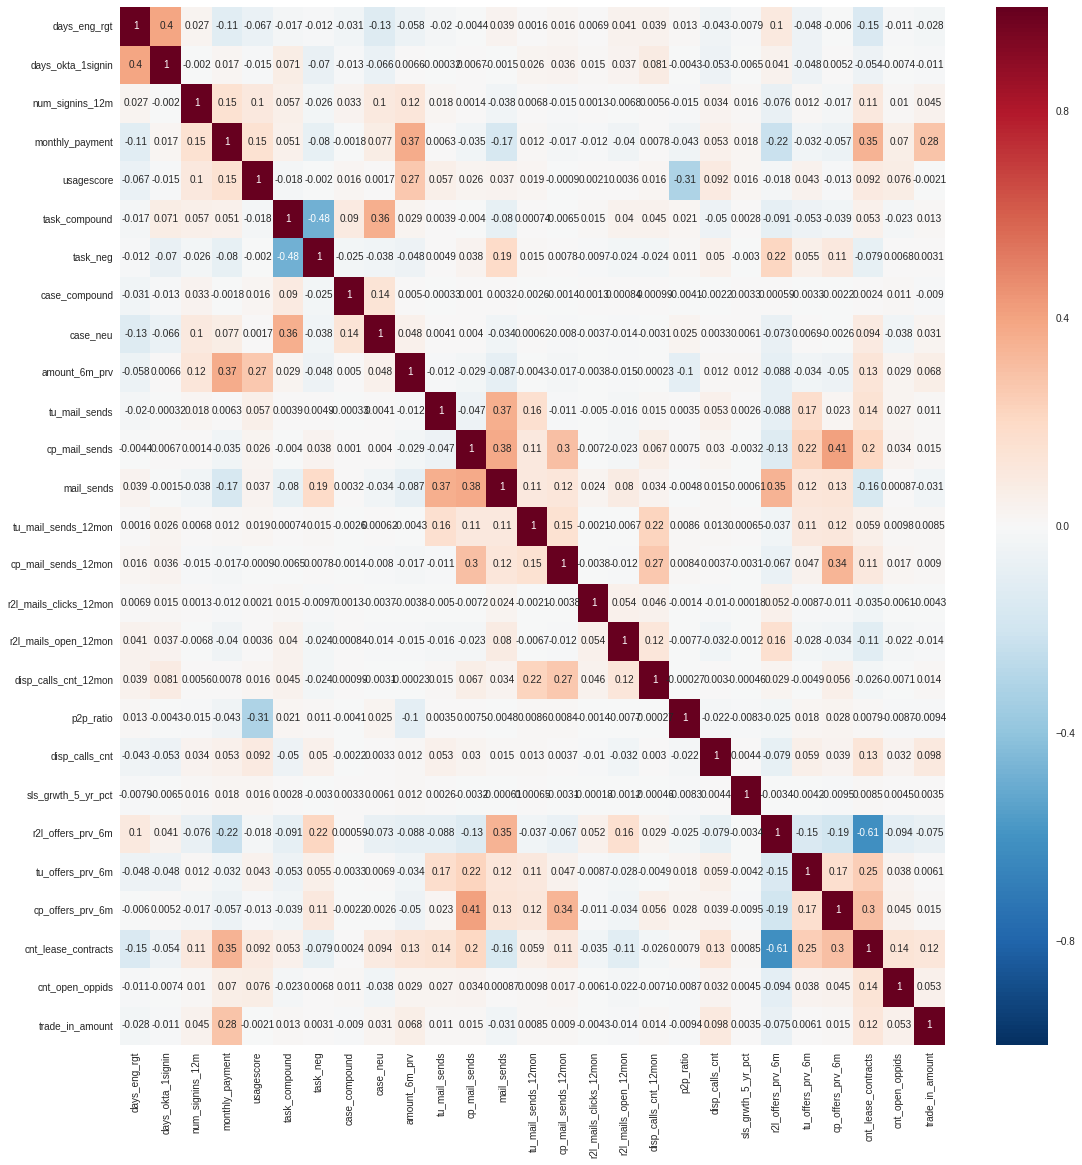

In [12]:
## numerical var with log transformation

md['disp_calls_cnt_log']=np.log(1+md['disp_calls_cnt'])
# md['sls_grwth_5_yr_pct_log']=np.log(101+md['sls_grwth_5_yr_pct'])

md['p2p_ratio']=(md['monthly_payment']*12)/(1+md['amount_12mon'])
md['p2p_ratio'][(md['amount_12mon']==0) & (md['monthly_payment']==0)] = 1
md['p2p_ratio'][md['p2p_ratio'] > np.quantile(md['p2p_ratio'],[0.99])[0]] = np.quantile(md['p2p_ratio'],[0.99])[0]


num_var_f=['days_eng_rgt','days_okta_1signin','num_signins_12m',
           'monthly_payment','usagescore',#'pieces_6m_prv',
#            'rstamt_prv_12m',
          'task_compound','task_neg',#'task_pos',
           'case_compound','case_neu',
           'amount_6m_prv',#'amt_grw_prv_mth',
          'tu_mail_sends','cp_mail_sends','mail_sends',
          'tu_mail_sends_12mon', 'cp_mail_sends_12mon',
          'r2l_mails_clicks_12mon',#'mails_clicks_12mon',
           'r2l_mails_open_12mon',#'mails_open_12mon', # impact is counter intuitive
          'disp_calls_cnt_12mon','p2p_ratio',
#            'disp_calls_cnt_log',
           'disp_calls_cnt','sls_grwth_5_yr_pct',
          'r2l_offers_prv_6m','tu_offers_prv_6m','cp_offers_prv_6m' , # can try 12m and prv qtr also
          'cnt_lease_contracts','cnt_open_oppids','trade_in_amount'] #,'list_minus_ti']

print(len(num_var_f))

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
fig.tight_layout()

corrMatrix = md[num_var_f].corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

## numerical variables final list obtained based on above eda and representatives from each type of variables
## few variables are again removed (commented) based on high correlation
# finally a list of 27 numerical variables obtained

In [39]:
for i in num_var_f:
    print('---------------')
    print(i)
    print(md[i].isnull().sum())
    print(md[i].isna().sum())
    print(md[i].describe())

---------------
days_eng_rgt
164497
164497
count    722223.000000
mean        761.769046
std         415.717900
min           1.000000
25%         399.000000
50%         796.000000
75%        1122.000000
max        1398.000000
Name: days_eng_rgt, dtype: float64
---------------
days_okta_1signin
81987
81987
count    804733.000000
mean        749.273472
std         301.636953
min           0.000000
25%         589.000000
50%         746.000000
75%         902.000000
max        1492.000000
Name: days_okta_1signin, dtype: float64
---------------
num_signins_12m
0
0
count    886720.000000
mean          6.457743
std           8.683320
min           0.000000
25%           0.000000
50%           2.000000
75%           9.000000
max          30.000000
Name: num_signins_12m, dtype: float64
---------------
monthly_payment
0
0
count    886720.000000
mean         55.999596
std          63.020717
min        -317.666667
25%          27.000000
50%          38.333333
75%          56.666667
max        46

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [40]:
## fitting a random forest classifier to check the variable importance

X = md[list(set(num_var_f)-set(['days_eng_rgt','days_okta_1signin']))]  #independent columns
#print(X[0:4])
scaler = StandardScaler()
X_std = pd.DataFrame(data=scaler.fit_transform(X), columns=X.columns)
del X
#print(X_std[0:4])
y = md['renewal']  
# print(y[0:4])

# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_std, y)

# Print the name and gini importance of each feature
var_imp={}
for i,j in zip(X_std.columns, clf.feature_importances_):
    var_imp[i]=j
#pd.DataFrame.from_dict(var_imp, orient='index')

In [41]:
## storing variables importance in data frame
var_imp={}
for i,j in zip(X_std.columns, clf.feature_importances_):
    var_imp[i]=j
var_imp_pd1=pd.DataFrame.from_dict(var_imp, orient='index')
var_imp_pd1.columns=['var_imp']
var_imp_pd1['var_name']=var_imp_pd1.index
var_imp_pd1.sort_values(by=['var_imp'],ascending=False)

,var_imp,var_name
amount_6m_prv,0.174214,amount_6m_prv
p2p_ratio,0.173646,p2p_ratio
monthly_payment,0.103760,monthly_payment
disp_calls_cnt,0.088957,disp_calls_cnt
num_signins_12m,0.082536,num_signins_12m
task_compound,0.067523,task_compound
task_neg,0.056561,task_neg
tu_offers_prv_6m,0.029590,tu_offers_prv_6m
case_neu,0.029587,case_neu
case_compound,0.028995,case_compound


In [42]:
## checking important variables using lasso regression
clf = LogisticRegression(penalty="l1",solver='liblinear',)
clf.fit(X_std,y)
thetaLasso=clf.coef_

In [43]:
## storing variables importance in data frame
var_imp={}
for i,j in zip(X_std.columns, clf.coef_.reshape(len(X_std.columns),1)):
    var_imp[i]=j
var_imp_pd=pd.DataFrame.from_dict(var_imp, orient='index')
var_imp_pd.columns=['var_beta']
var_imp_pd['var_beta_abs']=var_imp_pd['var_beta'].abs()
var_imp_pd['var_name']=var_imp_pd.index
var_imp_pd=var_imp_pd.sort_values(by=['var_beta_abs'],ascending=False)

In [44]:
# comparing important variables from Random forest and lasso regression

var_imp_pd=var_imp_pd.sort_values(by=['var_beta_abs'],ascending=False)
var_imp_pd1=var_imp_pd1.sort_values(by=['var_imp'],ascending=False)
var_imp_pd['rank_lasso']=np.arange(len(var_imp_pd))
var_imp_pd1['rank_rfc']=np.arange(len(var_imp_pd1))
print(var_imp_pd.shape)
print(var_imp_pd1.shape)
t=var_imp_pd.merge(var_imp_pd1, on='var_name', how='outer')
t=t.sort_values(by=['var_beta_abs'],ascending=False)
print('variables left out by RFC as unimp but Lasso find imp:')
print(t[(t.rank_lasso<=15) & (t.rank_rfc >15) ])
print('variables left out by Lasso as unimp but RFC find imp:')
print(t[(t.rank_lasso >15) & (t.rank_rfc <=15)]) ##lasso capture usage score to compensate for amount realted vars
t.sort_values(by=['rank_rfc']) ##
# print(t[(t.rank_lasso >=15) & (t.rank_rfc <=15)].shape[0])

## out of top 16 variable recommended by both methods 13 are common
## lasso identified case and task compound sentiment as less important 
##     (but task neg and case neutral sentiment sre identified as important as by Random forest)
## sls_grwth_5_yr_pct is less important acc to both methods
## tradeup and cross purchase offers are identified as important by both methods, so r2l offers can also be included in the list
## mail_sends is identified as important by random forest so cp_mail_sends can also be included in list

## it gives decent idea about important numerical variables

(25, 4)
(25, 3)
variables left out by RFC as unimp but Lasso find imp:
    var_beta  var_beta_abs             var_name  rank_lasso   var_imp  \
8   0.080765      0.080765    r2l_offers_prv_6m           8  0.005771   
9  -0.071715      0.071715  cp_mail_sends_12mon           9  0.005816   
12  0.044007      0.044007        cp_mail_sends          12  0.008920   

    rank_rfc  
8         21  
9         20  
12        17  
variables left out by Lasso as unimp but RFC find imp:
    var_beta  var_beta_abs            var_name  rank_lasso   var_imp  rank_rfc
19 -0.018316      0.018316       case_compound          19  0.028995         9
20 -0.017407      0.017407       task_compound          20  0.067523         5
22  0.013818      0.013818  sls_grwth_5_yr_pct          22  0.015821        14


,var_beta,var_beta_abs,var_name,rank_lasso,var_imp,rank_rfc
3,-0.343322,0.343322,amount_6m_prv,3,0.174214,0
5,-0.231117,0.231117,p2p_ratio,5,0.173646,1
2,-0.445911,0.445911,monthly_payment,2,0.103760,2
1,0.473876,0.473876,disp_calls_cnt,1,0.088957,3
13,-0.035720,0.035720,num_signins_12m,13,0.082536,4
20,-0.017407,0.017407,task_compound,20,0.067523,5
15,-0.033285,0.033285,task_neg,15,0.056561,6
11,-0.046922,0.046922,tu_offers_prv_6m,11,0.029590,7
10,-0.058054,0.058054,case_neu,10,0.029587,8
19,-0.018316,0.018316,case_compound,19,0.028995,9


In [45]:
# X_std['renewal']=md['renewal']

In [46]:
##--- information value
# max_bin = 20
# force_bin = 3
# final_iv, IV = data_vars(X_std,X_std.renewal)
# IV=IV.sort_values('IV',ascending=False)
# IV.columns=[x.lower() for x in IV.columns]
# IV['iv_rank']=np.arange(len(IV))
# print(IV)

                  var_name        iv  iv_rank
16       r2l_offers_prv_6m  0.054903        0
11         monthly_payment  0.048865        1
7         cp_offers_prv_6m  0.014100        2
23        tu_offers_prv_6m  0.013024        3
0            amount_6m_prv  0.008441        4
19                task_neg  0.007194        5
20         trade_in_amount  0.006151        6
5            cp_mail_sends  0.004577        7
10              mail_sends  0.004470        8
24              usagescore  0.003301        9
21           tu_mail_sends  0.002229       10
15    r2l_mails_open_12mon  0.001930       11
6      cp_mail_sends_12mon  0.001675       12
9     disp_calls_cnt_12mon  0.001497       13
8           disp_calls_cnt  0.001469       14
12         num_signins_12m  0.001313       15
2                 case_neu  0.000719       16
22     tu_mail_sends_12mon  0.000623       17
17      sls_grwth_5_yr_pct  0.000341       18
1            case_compound  0.000145       19
13               p2p_ratio  0.0001

In [107]:
# t=t.merge(IV, on='var_name', how='outer')
# t=t.sort_values(by=['var_beta_abs'],ascending=False)

In [108]:
# IV=IV.sort_values('iv',ascending=False)
# IV

,var_name,iv,iv_rank
10,list_minus_ti,8.158611e-04,0
9,disp_calls_cnt_12mon,8.154726e-04,1
4,cnt_open_oppids,7.956000e-04,2
14,monthly_payment,7.945111e-04,3
3,cnt_lease_open_oppids,6.726132e-04,4
20,rstamt_prv_12m,6.474532e-04,5
5,cp_mail_sends,5.642130e-04,6
26,tu_offers_prv_6m,5.374067e-04,7
7,cp_offers_prv_6m,3.959593e-04,8
6,cp_mail_sends_12mon,3.744031e-04,9


In [109]:
# t=t.sort_values(by=['rank_rfc'])
# t[t.rank_rfc<=15]

,var_beta,var_beta_abs,var_name,rank_lasso,var_imp,rank_rfc,iv,iv_rank
1,-0.678339,0.678339,monthly_payment,1,0.136082,0,7.945111e-04,3
3,0.588272,0.588272,disp_calls_cnt,3,0.110324,1,2.004760e-04,15
7,-0.203652,0.203652,p2p_ratio,7,0.086544,2,8.704242e-05,20
17,0.047487,0.047487,amount_6m_prv,17,0.080219,3,2.541296e-04,13
2,-0.639481,0.639481,pieces_6m_prv,2,0.079750,4,7.327633e-05,22
8,0.166174,0.166174,task_compound,8,0.078819,5,6.289253e-05,23
6,0.282129,0.282129,list_minus_ti,6,0.077686,6,8.158611e-04,0
18,0.041508,0.041508,amt_grw_prv_qtr,18,0.076631,7,4.652811e-08,27
9,0.135775,0.135775,case_compound,9,0.055502,8,1.830833e-05,24
10,-0.131715,0.131715,rstamt_prv_12m,10,0.046728,9,6.474532e-04,5


# checking the distribution of few categorical vars

In [14]:
## function to perform chi square test on categorical varibales

def chi_sq_func(i,prob=0.95):
    d_ch=md[(md[i].notnull()) & (md.cmp_base_flag=='Yes')]
    contingency_table = pd.crosstab(
        d_ch[d_ch[i].notnull()]['renewal'],
        d_ch[d_ch[i].notnull()][i],
        margins = True
    )
    tab=contingency_table.iloc[0:(contingency_table.shape[0]-1),0:(contingency_table.shape[1]-1)]
    stat, p, dof, expected = chi2_contingency(tab)
    print('dof=%d' % dof)
    critical = chi2.ppf(prob, dof)
    print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
    print('p-value is: {}'.format(p))
    if abs(stat) >= critical:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
    return()

In [48]:
# chi square test of independence for categorical vars
from scipy.stats import chi2_contingency
from scipy.stats import chi2

for i in cat_var:
    print('--- chi square test for column: '+i)
    #if md[md[i].notnull()][i].nunique()>1:
    if md[(md[i].notnull()) & (md.cmp_base_flag=='Yes')][i].nunique()>1:
        chi_sq_func(i)
    else:
        print('not enough variation to perform chi sq test')

--- chi square test for column: lease_timing_segment
dof=10
probability=0.950, critical=18.307, stat=47051.819
p-value is: 0.0
Dependent (reject H0)
--- chi square test for column: rental_timing_segment
dof=7
probability=0.950, critical=14.067, stat=19370.816
p-value is: 0.0
Dependent (reject H0)
--- chi square test for column: eligibility
dof=1
probability=0.950, critical=3.841, stat=6526.345
p-value is: 0.0
Dependent (reject H0)
--- chi square test for column: usage
dof=3
probability=0.950, critical=7.815, stat=4573.862
p-value is: 0.0
Dependent (reject H0)
--- chi square test for column: campaign
dof=14
probability=0.950, critical=23.685, stat=30578.145
p-value is: 0.0
Dependent (reject H0)
--- chi square test for column: campaign_type
dof=1
probability=0.950, critical=3.841, stat=19341.776
p-value is: 0.0
Dependent (reject H0)
--- chi square test for column: title
dof=121
probability=0.950, critical=147.674, stat=11698.412
p-value is: 0.0
Dependent (reject H0)
--- chi square test f

In [50]:
## checking distribution of renewal across all categorical var 
for i in cat_var:
    l=md.groupby([i,'renewal'],as_index=False )['cmp_base_flag'].count()
    r=md.groupby([i],as_index=False )['cmp_base_flag'].count()
    r.rename(columns={"cmp_base_flag": "total"}, inplace=True)
    l=l.merge(r, on=i, how='left')
    l['prop']=(l['cmp_base_flag']/l['total'])*100
    print('total observations for varaiable-'+i+' are {}'.format(md[i].count().sum()))
#     print('missing value prop: {}'.format(md[i].isnull().sum()/md.shape[0]))
    print(l[(l.renewal==1) & (l.cmp_base_flag >30) ])
#     print('distribution of renewals where it is missing')
#     p=md[md[i].isnull()].groupby(['renewal'],as_index=False )['cmp_base_flag'].count()
#     p['prop']=(p['cmp_base_flag']/md[i].isnull().sum())*100
#     print(p)

total observations for varaiable-lease_timing_segment are 886720
   lease_timing_segment  renewal  cmp_base_flag   total       prop
1               Unknown        1           4058   49556   8.188716
3                a. <-8        1           2505   57022   4.393041
5                b. SLP        1           3375   41677   8.097992
7                c. 0-1        1           2717   20802  13.061244
9                d. 2-4        1           4546   42832  10.613560
11               e. 5-7        1           4732   53379   8.864909
13               f. 8-9        1           3942   38175  10.326130
15             g. 10-12        1          13086   83598  15.653485
17             h. 13-15        1          11674   64254  18.168519
19               i. >15        1           1596  107978   1.478079
21            not_lease        1           5798  327447   1.770668
total observations for varaiable-rental_timing_segment are 886720
   rental_timing_segment  renewal  cmp_base_flag   total      pro

total observations for varaiable-naics2 are 886720
                                               naics2  renewal  cmp_base_flag  \
1                     Accommodation and Food Services        1            658   
3   Administrative and Support and Waste Managemen...        1           2378   
5          Agriculture, Forestry, Fishing and Hunting        1            324   
7                 Arts, Entertainment, and Recreation        1            705   
9                                        Construction        1           3774   
11                               Educational Services        1            766   
13                              Finance and Insurance        1           3717   
15                  Health Care and Social Assistance        1           7399   
17                                        Information        1            648   
19            Management of Companies and Enterprises        1             58   
21                                      Manufacturing     

total observations for varaiable-materialgroup are 886720
   materialgroup  renewal  cmp_base_flag   total       prop
1             C+        1            255    2687   9.490138
3       C-series        1            290   31761   0.913069
5          DM1xx        1          27484  267569  10.271743
7          DM2xx        1           3603   37494   9.609538
9          DM3xx        1           1515   16757   9.040998
11     DM3xx/4xx        1           1076   15989   6.729627
13         DM4xx        1           3036   44989   6.748316
15          K7xx        1          20493  459467   4.460168
19      P-series        1            263    9672   2.719189


In [15]:
cat_var_f=list(set(cat_var)-set(['finalequip','naicscd','naics2','naics3']))

# cat_var_f
# for i in cat_var_f:
#     print(i)
#     print(md[i].isnull().sum())

In [34]:
##--- information value for categorical vars

max_bin = 20
force_bin = 4

X_std=md[cat_var_f]
X_std['renewal']=md['renewal']

final_iv, IV = data_vars(X_std,X_std.renewal)
del X_std

IV=IV.sort_values('IV',ascending=False)
IV.columns=[x.lower() for x in IV.columns]
IV['iv_rank']=np.arange(len(IV))
print(IV)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


                 var_name        iv  iv_rank
12   lease_timing_segment  0.915039        0
4                campaign  0.897269        1
16       outreach_channel  0.837999        2
15           multichannel  0.530210        3
17          outreach_flag  0.530210        4
21  rental_timing_segment  0.506039        5
5           campaign_type  0.502386        6
7            contract_lro  0.502386        7
13                loyalty  0.418757        8
14          materialgroup  0.247414        9
25                  title  0.245766       10
22      shipping_eligible  0.129129       11
3             box_segment  0.116680       12
8             eligibility  0.113055       13
26                  usage  0.082443       14
27      your_account_flag  0.082096       15
23              stagename  0.072432       16
19                 pbiseg  0.023396       17
24       third_party_flag  0.015254       18
2            autoink_flag  0.003707       19
20          promoter_flag  0.002906       20
11        

## checking important Variables Numerical + categorical

In [16]:
## creating a dataset with numerical and dummified categorical variables

X = md[list(set(num_var_f)-set(['days_eng_rgt','days_okta_1signin']))]  #independent columns

scaler = StandardScaler()
X_std = pd.DataFrame(data=scaler.fit_transform(X), columns=X.columns).reset_index(drop=True) 
del X

ct=pd.get_dummies(md[cat_var_f],drop_first=True).reset_index(drop=True) 

X=pd.concat([X_std,ct],axis=1)
print(X.shape)

del X_std
del ct

y = md['renewal']  


(886720, 261)


In [30]:
# Create a random forest classifier

clf1 = RandomForestClassifier(n_estimators=500, random_state=0, n_jobs=-1)

# Train the classifier
clf1.fit(X, y)
# clf.fit(X[list(set(X.columns)-set(['naicscd']))], y)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [31]:
## storing variable importances in a dataset
var_imp={}
for i,j in zip(list(X.columns), clf1.feature_importances_):
# for i,j in zip(list(X.columns), clf.feature_importances_):
    var_imp[i]=j
var_imp_pd=pd.DataFrame.from_dict(var_imp, orient='index')
var_imp_pd.columns=['var_imp']
var_imp_pd['var_name']=var_imp_pd.index
var_imp_pd=var_imp_pd.sort_values(by=['var_imp'],ascending=False)
var_imp_pd['rank_rfc']=np.arange(len(var_imp_pd))
var_imp_pd[0:25]

,var_imp,var_name,rank_rfc
p2p_ratio,0.077197,p2p_ratio,0
amount_6m_prv,0.076105,amount_6m_prv,1
monthly_payment,0.050371,monthly_payment,2
disp_calls_cnt,0.049922,disp_calls_cnt,3
num_signins_12m,0.046766,num_signins_12m,4
task_compound,0.040090,task_compound,5
task_neg,0.034150,task_neg,6
loyalty_Other,0.021524,loyalty_Other,7
case_neu,0.020041,case_neu,8
case_compound,0.019131,case_compound,9


In [20]:
y_pred = clf.predict(X)
accuracy_score(y, y_pred)

0.9999909779862866

In [21]:
# from sklearn.metrics import confusion_matrix
# confusion_matrix(y, y_pred)

array([[828691,      0],
       [     8,  58021]])

In [23]:
## fitting lasso regression to identify the important variables
clf = LogisticRegression(penalty="l1",solver='liblinear')

clf.fit(X,y)
thetaLasso=clf.coef_

In [24]:
y_pred = clf.predict(X)
print(accuracy_score(y, y_pred))
confusion_matrix(y, y_pred)

0.9354260645976182


array([[825457,   3234],
       [ 54025,   4004]])

In [26]:
## storing variable importances in a dataset

var_imp1={}
for i,j in zip(X.columns, clf.coef_.reshape(len(X.columns),1)):
    var_imp1[i]=j
var_imp_pd1=pd.DataFrame.from_dict(var_imp1, orient='index')
var_imp_pd1.columns=['var_beta']
var_imp_pd1['var_beta_abs']=var_imp_pd1['var_beta'].abs()
var_imp_pd1['var_name']=var_imp_pd1.index
var_imp_pd1=var_imp_pd1.sort_values(by=['var_beta_abs'],ascending=False)
var_imp_pd1['rank_lasso']=np.arange(len(var_imp_pd1))

In [27]:
print(var_imp_pd1.shape)
print(var_imp_pd1[var_imp_pd1.var_beta_abs==0].shape)

(261, 4)
(92, 4)


In [33]:
## comparing both methods results
t=var_imp_pd.merge(var_imp_pd1, on='var_name', how='outer')
t=t.sort_values(by=['rank_lasso'])
print('variables left out by RFC as unimp but Lasso find imp: ')
print(t[(t.rank_lasso<=30) & (t.rank_rfc >30) ].shape[0])
#print(t[(t.rank_lasso<=30) & (t.rank_rfc >30) ])
print('variables left out by Lasso as unimp but RFC find imp:')
print(t[(t.rank_lasso > 30) & (t.rank_rfc <=30) ].shape[0])
#print(t[(t.rank_lasso >30) & (t.rank_rfc <=30)]) ##lasso capture usage score to compensate for amount realted vars
t[(t.rank_lasso <= 30) | (t.rank_rfc <=30)].sort_values(by=['rank_rfc']) ##

## most of the variables recommended are different
## Random forest results looks more reliables ---because the fitted lasso model predicted renewal poorly acc ~93%, recall < 10% 
## random forest results are close to resluts obtained when only numericl variables are considered
## it seems that due to large number of dummy variables lasso may not be reliable

## need to check manually-- maybe removing un important categorical variables using IV or
##        converting categorical variables to numeric using woe/ some other encoding

variables left out by RFC as unimp but Lasso find imp: 
29
variables left out by Lasso as unimp but RFC find imp:
29


,var_imp,var_name,rank_rfc,var_beta,var_beta_abs,rank_lasso
0,7.719682e-02,p2p_ratio,0,-0.160280,0.160280,106
1,7.610541e-02,amount_6m_prv,1,0.013849,0.013849,159
2,5.037061e-02,monthly_payment,2,-0.729959,0.729959,30
3,4.992249e-02,disp_calls_cnt,3,0.214695,0.214695,93
4,4.676637e-02,num_signins_12m,4,-0.071067,0.071067,130
5,4.009047e-02,task_compound,5,0.018512,0.018512,156
6,3.415012e-02,task_neg,6,-0.043618,0.043618,143
7,2.152445e-02,loyalty_Other,7,0.914673,0.914673,19
8,2.004134e-02,case_neu,8,-0.062906,0.062906,134
9,1.913054e-02,case_compound,9,-0.020119,0.020119,155
